# Machine learning for titer prediction
The proteomics data we have for isoprenol titer is extremely underutilized - I'd like to do some ML on it to see if we can learn anything about predicting titer, or about biological correlations between proteins. 

In this notebook I try to answer the question: "How many different phenotypes (proteomics profiles) can yield high-titer strains?". Another way to think about this question is: "How many peaks does our fitness landscape - as defined by proteomics - have?". 

To answer this question, I first do distance based clustering on the highest performing strains. Looking at the top 10 highest titers yields 3 different clusters of proteomics measurements. Then, I do PCA on the proteomics of a small set of high-titer strains and try to interpret the PCA weightings to characterize the different clusters.

In [1]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install adjustText
from adjustText import adjust_text

## Import data

In [3]:
data_file = './data/normalized_proteomics_pivot.csv'
data_file = './data/normalized_proteomics_pivot_c0-c6.csv'
omics = pd.read_csv(data_file, index_col=0)
omics

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                     
Control-R10_c0       0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0       1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0       1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0       0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0       0.920443  1.294411  1.084229  1.028170  0.825054   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.831806  1.079450  0.040345  0.591196  0.433515   
PP_5419-R3_c0        0.854970  1.111790  0.310904  0.663168  0.667366   
PP_5420-R1_c0        1.004817  1.104894  0.442635  0.748915  0.337878   
PP_5420-R2_c0        1.147398  0.819752  0.340405  0.602163  0.287466   
PP_5420-R3_c0        1.153457  0.881563  0.459441  0.666740  0.224281   

                      PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                    ...   
Control-R10_c0       0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0       0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0       1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0       0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0       0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                       ...       ...       ...       ...       ...  ...   
PP_5419-R2_c0        1.591181  0.635789  0.521773  0.651952  0.840361  ...   
PP_5419-R3_c0        2.381747  0.622027  0.634366  1.168989  0.809204  ...   
PP_5420-R1_c0        1.798357  0.237874  0.392700  0.869069  0.328949  ...   
PP_5420-R2_c0        2.221226  0.257740  0.290564  0.814532  0.307289  ...   
PP_5420-R3_c0        1.211735  0.303645  0.855985  0.711602  0.460836  ...   

                      PP_5414   PP_5415   PP_5416   PP_5417   PP_5418  \
line_name_rep_cycle                                                     
Control-R10_c0       0.957637  0.951346  0.792854  0.952586  0.000000   
Control-R11_c0       1.027012  0.988927  0.872016  1.053211  0.022315   
Control-R12_c0       1.055696  1.031219  0.890724  0.955814  6.881715   
Control-R13_c0       1.139495  1.072695  1.008304  1.037332  0.021247   
Control-R14_c0       1.055021  0.991063  0.991993  0.899485  0.045492   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.714721  0.742051  0.630470  0.871891  0.028549   
PP_5419-R3_c0        0.715938  0.756146  0.596430  0.767842  0.029056   
PP_5420-R1_c0        0.766955  0.645999  0.726382  0.892056  0.084788   
PP_5420-R2_c0        0.757027  0.652865  0.816321  0.975408  0.427833   
PP_5420-R3_c0        0.745951  0.834641  0.619682  1.014742  0.066089   

                     SPy_1046   YNR043W  b4055 JW4015       neo  isoprenol  
line_name_rep_cycle                                                         
Control-R10_c0       1.275427  0.988950      1.075991  1.110129   1.024392  
Control-R11_c0       1.095618  1.066124      1.224033  1.058979   1.120367  
Control-R12_c0       1.179865  1.025106      0.905480  1.131022   1.178920  
Control-R13_c0       0.819190  1.014700      0.904057  0.896219   0.720284  
Control-R14_c0       0.901863  1.047413      0.997991  1.083941   1.030501  
...                       ...       ...           ...       ...        ...  
PP_5419-R2_c0        0.036465  0.972795      1.222933  1.008801   2.153361  
PP_5419-R3_c0        0.037112  0.938466      1.087679  1.079077   2.397354  
PP_5420-R1_c0        0.030160  0.705855      0.730318  1.447907   0.484521  
PP_5420-R2_c0        0.037505  0.822675      0.441548  1.220464   0.527125  
PP_5420-R3_c0        0.028287  0.870521      0.605938  1.663963   0.556424  

[1512 rows x 1646 columns]

### Drop wierd runs from C3

In [4]:
omics = omics.drop(['PP_0815_PP_1317-R1_c3',
                    'PP_0815_PP_1317-R2_c3',
                    'PP_0815_PP_1317-R3_c3',
                    'PP_1317-R1_c3',
                    'PP_1317-R2_c3',
                    'PP_1317-R3_c3'
                   ]
                  )

## Merge means by replicate

### Drop rows/columns with missing data

In [5]:
omics.loc[omics['isoprenol'].isna(), 'isoprenol']
omics = omics.dropna(axis = 0, how = 'any', subset=['isoprenol'])
omics

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                     
Control-R10_c0       0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0       1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0       1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0       0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0       0.920443  1.294411  1.084229  1.028170  0.825054   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.831806  1.079450  0.040345  0.591196  0.433515   
PP_5419-R3_c0        0.854970  1.111790  0.310904  0.663168  0.667366   
PP_5420-R1_c0        1.004817  1.104894  0.442635  0.748915  0.337878   
PP_5420-R2_c0        1.147398  0.819752  0.340405  0.602163  0.287466   
PP_5420-R3_c0        1.153457  0.881563  0.459441  0.666740  0.224281   

                      PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                    ...   
Control-R10_c0       0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0       0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0       1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0       0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0       0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                       ...       ...       ...       ...       ...  ...   
PP_5419-R2_c0        1.591181  0.635789  0.521773  0.651952  0.840361  ...   
PP_5419-R3_c0        2.381747  0.622027  0.634366  1.168989  0.809204  ...   
PP_5420-R1_c0        1.798357  0.237874  0.392700  0.869069  0.328949  ...   
PP_5420-R2_c0        2.221226  0.257740  0.290564  0.814532  0.307289  ...   
PP_5420-R3_c0        1.211735  0.303645  0.855985  0.711602  0.460836  ...   

                      PP_5414   PP_5415   PP_5416   PP_5417   PP_5418  \
line_name_rep_cycle                                                     
Control-R10_c0       0.957637  0.951346  0.792854  0.952586  0.000000   
Control-R11_c0       1.027012  0.988927  0.872016  1.053211  0.022315   
Control-R12_c0       1.055696  1.031219  0.890724  0.955814  6.881715   
Control-R13_c0       1.139495  1.072695  1.008304  1.037332  0.021247   
Control-R14_c0       1.055021  0.991063  0.991993  0.899485  0.045492   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.714721  0.742051  0.630470  0.871891  0.028549   
PP_5419-R3_c0        0.715938  0.756146  0.596430  0.767842  0.029056   
PP_5420-R1_c0        0.766955  0.645999  0.726382  0.892056  0.084788   
PP_5420-R2_c0        0.757027  0.652865  0.816321  0.975408  0.427833   
PP_5420-R3_c0        0.745951  0.834641  0.619682  1.014742  0.066089   

                     SPy_1046   YNR043W  b4055 JW4015       neo  isoprenol  
line_name_rep_cycle                                                         
Control-R10_c0       1.275427  0.988950      1.075991  1.110129   1.024392  
Control-R11_c0       1.095618  1.066124      1.224033  1.058979   1.120367  
Control-R12_c0       1.179865  1.025106      0.905480  1.131022   1.178920  
Control-R13_c0       0.819190  1.014700      0.904057  0.896219   0.720284  
Control-R14_c0       0.901863  1.047413      0.997991  1.083941   1.030501  
...                       ...       ...           ...       ...        ...  
PP_5419-R2_c0        0.036465  0.972795      1.222933  1.008801   2.153361  
PP_5419-R3_c0        0.037112  0.938466      1.087679  1.079077   2.397354  
PP_5420-R1_c0        0.030160  0.705855      0.730318  1.447907   0.484521  
PP_5420-R2_c0        0.037505  0.822675      0.441548  1.220464   0.527125  
PP_5420-R3_c0        0.028287  0.870521      0.605938  1.663963   0.556424  

[1506 rows x 1646 columns]

In [6]:
omics = omics.dropna(axis = 1, how = 'any')
omics

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                     
Control-R10_c0       0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0       1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0       1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0       0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0       0.920443  1.294411  1.084229  1.028170  0.825054   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.831806  1.079450  0.040345  0.591196  0.433515   
PP_5419-R3_c0        0.854970  1.111790  0.310904  0.663168  0.667366   
PP_5420-R1_c0        1.004817  1.104894  0.442635  0.748915  0.337878   
PP_5420-R2_c0        1.147398  0.819752  0.340405  0.602163  0.287466   
PP_5420-R3_c0        1.153457  0.881563  0.459441  0.666740  0.224281   

                      PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                    ...   
Control-R10_c0       0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0       0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0       1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0       0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0       0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                       ...       ...       ...       ...       ...  ...   
PP_5419-R2_c0        1.591181  0.635789  0.521773  0.651952  0.840361  ...   
PP_5419-R3_c0        2.381747  0.622027  0.634366  1.168989  0.809204  ...   
PP_5420-R1_c0        1.798357  0.237874  0.392700  0.869069  0.328949  ...   
PP_5420-R2_c0        2.221226  0.257740  0.290564  0.814532  0.307289  ...   
PP_5420-R3_c0        1.211735  0.303645  0.855985  0.711602  0.460836  ...   

                      PP_5414   PP_5415   PP_5416   PP_5417   PP_5418  \
line_name_rep_cycle                                                     
Control-R10_c0       0.957637  0.951346  0.792854  0.952586  0.000000   
Control-R11_c0       1.027012  0.988927  0.872016  1.053211  0.022315   
Control-R12_c0       1.055696  1.031219  0.890724  0.955814  6.881715   
Control-R13_c0       1.139495  1.072695  1.008304  1.037332  0.021247   
Control-R14_c0       1.055021  0.991063  0.991993  0.899485  0.045492   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.714721  0.742051  0.630470  0.871891  0.028549   
PP_5419-R3_c0        0.715938  0.756146  0.596430  0.767842  0.029056   
PP_5420-R1_c0        0.766955  0.645999  0.726382  0.892056  0.084788   
PP_5420-R2_c0        0.757027  0.652865  0.816321  0.975408  0.427833   
PP_5420-R3_c0        0.745951  0.834641  0.619682  1.014742  0.066089   

                     SPy_1046   YNR043W  b4055 JW4015       neo  isoprenol  
line_name_rep_cycle                                                         
Control-R10_c0       1.275427  0.988950      1.075991  1.110129   1.024392  
Control-R11_c0       1.095618  1.066124      1.224033  1.058979   1.120367  
Control-R12_c0       1.179865  1.025106      0.905480  1.131022   1.178920  
Control-R13_c0       0.819190  1.014700      0.904057  0.896219   0.720284  
Control-R14_c0       0.901863  1.047413      0.997991  1.083941   1.030501  
...                       ...       ...           ...       ...        ...  
PP_5419-R2_c0        0.036465  0.972795      1.222933  1.008801   2.153361  
PP_5419-R3_c0        0.037112  0.938466      1.087679  1.079077   2.397354  
PP_5420-R1_c0        0.030160  0.705855      0.730318  1.447907   0.484521  
PP_5420-R2_c0        0.037505  0.822675      0.441548  1.220464   0.527125  
PP_5420-R3_c0        0.028287  0.870521      0.605938  1.663963   0.556424  

[1506 rows x 1646 columns]

### Merge by replicate

In [7]:
omics_mean = omics.copy()
omics_mean['cycle'] = [x[-1] for x in omics_mean.index.values]
omics_mean['cycle'].value_counts()
# omics_mean['line_name'] = omics_mean.apply(lambda x: x.index.values.split('-')[0], axis = 1)
omics_mean['line_name'] = [f"{x.split('-')[0]}_c{x[-1]}" for x in omics_mean.index.values]
omics_mean['is_control'] = ['ontrol' in x for x in omics_mean['line_name']]
omics_mean.loc[omics_mean['is_control'], 'line_name'] = omics_mean.loc[
    omics_mean['is_control'], 'line_name'].apply(lambda x: f'Control_c{x[-1]}')
omics_metadata = omics_mean[['cycle', 'is_control']].copy()
omics_mean = omics_mean.drop(['cycle', 'is_control'], axis = 1)

omics_mean = omics_mean.groupby('line_name').mean()
omics_mean.shape

(472, 1646)

In [8]:
print(f"Number of measurements per cycle:\n{omics_metadata['cycle'].value_counts()}")

Number of measurements per cycle:
cycle
0    387
1    192
2    192
6    189
5    186
4    183
3    177
Name: count, dtype: int64


In [9]:
protein_measurements = omics.columns[:-1]
protein_measurements.shape

(1645,)

In [10]:
X = omics[protein_measurements]
y = omics['isoprenol']
X_mean = omics_mean[protein_measurements]
y_mean = omics_mean['isoprenol']
X

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                     
Control-R10_c0       0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0       1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0       1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0       0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0       0.920443  1.294411  1.084229  1.028170  0.825054   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.831806  1.079450  0.040345  0.591196  0.433515   
PP_5419-R3_c0        0.854970  1.111790  0.310904  0.663168  0.667366   
PP_5420-R1_c0        1.004817  1.104894  0.442635  0.748915  0.337878   
PP_5420-R2_c0        1.147398  0.819752  0.340405  0.602163  0.287466   
PP_5420-R3_c0        1.153457  0.881563  0.459441  0.666740  0.224281   

                      PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                    ...   
Control-R10_c0       0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0       0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0       1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0       0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0       0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                       ...       ...       ...       ...       ...  ...   
PP_5419-R2_c0        1.591181  0.635789  0.521773  0.651952  0.840361  ...   
PP_5419-R3_c0        2.381747  0.622027  0.634366  1.168989  0.809204  ...   
PP_5420-R1_c0        1.798357  0.237874  0.392700  0.869069  0.328949  ...   
PP_5420-R2_c0        2.221226  0.257740  0.290564  0.814532  0.307289  ...   
PP_5420-R3_c0        1.211735  0.303645  0.855985  0.711602  0.460836  ...   

                      PP_5413   PP_5414   PP_5415   PP_5416   PP_5417  \
line_name_rep_cycle                                                     
Control-R10_c0       0.950618  0.957637  0.951346  0.792854  0.952586   
Control-R11_c0       1.020609  1.027012  0.988927  0.872016  1.053211   
Control-R12_c0       0.985870  1.055696  1.031219  0.890724  0.955814   
Control-R13_c0       1.029636  1.139495  1.072695  1.008304  1.037332   
Control-R14_c0       1.063534  1.055021  0.991063  0.991993  0.899485   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0        0.685504  0.714721  0.742051  0.630470  0.871891   
PP_5419-R3_c0        0.680503  0.715938  0.756146  0.596430  0.767842   
PP_5420-R1_c0        0.678373  0.766955  0.645999  0.726382  0.892056   
PP_5420-R2_c0        0.688042  0.757027  0.652865  0.816321  0.975408   
PP_5420-R3_c0        0.702694  0.745951  0.834641  0.619682  1.014742   

                      PP_5418  SPy_1046   YNR043W  b4055 JW4015       neo  
line_name_rep_cycle                                                        
Control-R10_c0       0.000000  1.275427  0.988950      1.075991  1.110129  
Control-R11_c0       0.022315  1.095618  1.066124      1.224033  1.058979  
Control-R12_c0       6.881715  1.179865  1.025106      0.905480  1.131022  
Control-R13_c0       0.021247  0.819190  1.014700      0.904057  0.896219  
Control-R14_c0       0.045492  0.901863  1.047413      0.997991  1.083941  
...                       ...       ...       ...           ...       ...  
PP_5419-R2_c0        0.028549  0.036465  0.972795      1.222933  1.008801  
PP_5419-R3_c0        0.029056  0.037112  0.938466      1.087679  1.079077  
PP_5420-R1_c0        0.084788  0.030160  0.705855      0.730318  1.447907  
PP_5420-R2_c0        0.427833  0.037505  0.822675      0.441548  1.220464  
PP_5420-R3_c0        0.066089  0.028287  0.870521      0.605938  1.663963  

[1506 rows x 1645 columns]

In [11]:
y

line_name_rep_cycle
Control-R10_c0    1.024392
Control-R11_c0    1.120367
Control-R12_c0    1.178920
Control-R13_c0    0.720284
Control-R14_c0    1.030501
                    ...   
PP_5419-R2_c0     2.153361
PP_5419-R3_c0     2.397354
PP_5420-R1_c0     0.484521
PP_5420-R2_c0     0.527125
PP_5420-R3_c0     0.556424
Name: isoprenol, Length: 1506, dtype: float64

In [12]:
omics_index = omics.index.values
cycle_label = [int(x[-1]) for x in omics_index]
num_grna = [x.count('PP') for x in omics_index]
is_control = [1 if 'ontrol' in x else 0 for x in omics_index]

### Scale data for ML

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X_norm
X_norm_df = X.copy()
X_norm_df.iloc[:,:] = X_norm
X_norm_df

scaler2 = StandardScaler()
X_mean_norm = scaler2.fit_transform(X_mean)
X_mean_norm_df = X_mean.copy()
X_mean_norm_df.iloc[:,:] = X_mean_norm

## "Machine learning"
Want to try some basic sklearn on the data.

### PCA on individual replicates
See how well PCA can fit the data (how many components required) and whether PCA shows any obvious patterns with titer.

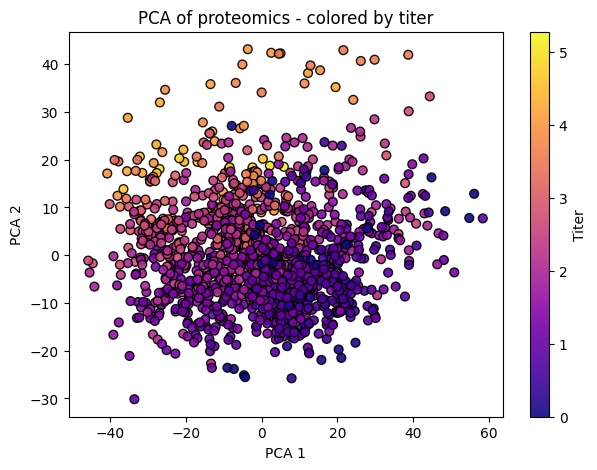

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
X_pca = pca.fit_transform(X_norm)
fig, ax = plt.subplots(figsize = (7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c = y, s = 40, alpha = 0.9, edgecolors='k', cmap = 'plasma')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
cbar = plt.colorbar(label = 'Titer')
# cbar.ax.set_ylabel('Titer')

plt.title('PCA of proteomics - colored by titer')
fig.savefig('./figures/PCA_colored_by_titer.png')

In [15]:
X_pca.shape

(1506, 10)

#### Coloring PCA by different descriptors
Does PCA tell us anything about:
- titer: no prior expectation
- cycle: Hopefully the cycles are all overlapping to some extent - otherwise there's a proteomic signature between cycles that could be confounding.
- num_grna: Hopefully these all overlap
- controls: Hopefully the controls from all cycles overlap

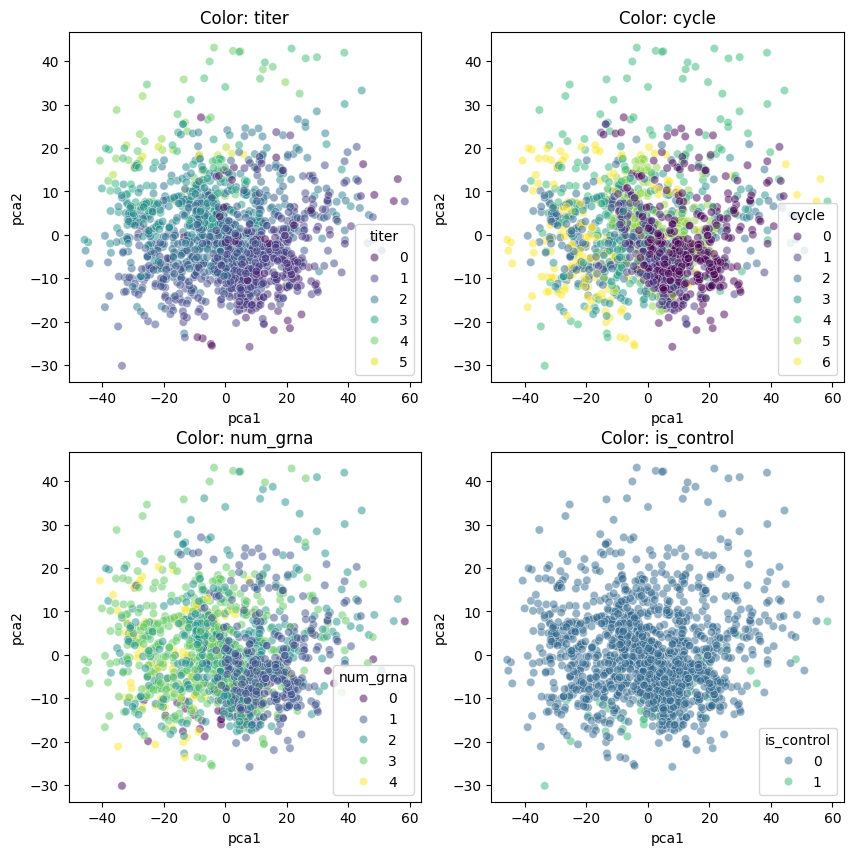

In [16]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(pca1 = X_pca[:,0], pca2 = X_pca[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'pca1', y = 'pca2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')
    

#### Looking at explained variance

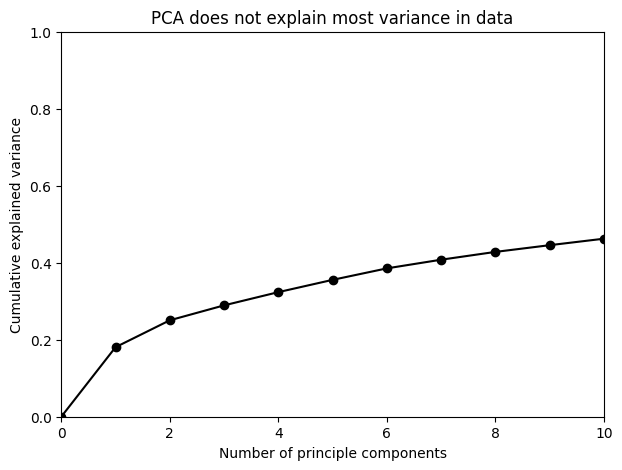

In [17]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PCA does not explain most variance in data')
fig.savefig('./figures/PCA_var_exp.png')

### Exploring differences between cycles
PCA shows that the first PCA dimension fully separates the two cycles. What variables are most associated with PC1?

In [18]:
weights = pca.components_
weights.shape

(10, 1645)

In [19]:
weights_df = pd.DataFrame(dict(ft = protein_measurements, pca1 = weights[0,:], pca2 = weights[1,:]))
weights_df

ft      pca1      pca2
0          MM_1762 -0.022995  0.015671
1          PP_0001 -0.026170 -0.027566
2          PP_0002 -0.018438 -0.032873
3          PP_0003 -0.035686 -0.027979
4          PP_0004 -0.023300 -0.016878
...            ...       ...       ...
1640       PP_5418 -0.001436  0.004440
1641      SPy_1046 -0.014366  0.001877
1642       YNR043W -0.015974  0.009366
1643  b4055 JW4015  0.005596  0.006246
1644           neo -0.018402 -0.001571

[1645 rows x 3 columns]

identify top 10 PC1 components

In [20]:
top_10_pc1 = weights_df.sort_values(by='pca1', ascending = False)['ft'].head(10)
top_10_pc1

170    PP_0454
7      PP_0009
188    PP_0472
165    PP_0449
159    PP_0443
177    PP_0461
941    PP_2680
750    PP_1905
189    PP_0473
183    PP_0467
Name: ft, dtype: object

In [21]:
df_top10pcs = X_norm_df.loc[:, top_10_pc1]
df_top10pcs['cycle'] = [int(x[-1]) for x in df_top10pcs.index]

In [22]:
df_top10pcs

PP_0454   PP_0009   PP_0472   PP_0449   PP_0443  \
line_name_rep_cycle                                                     
Control-R10_c0       0.294060  0.582960  0.260959  0.510376 -0.055794   
Control-R11_c0       0.457176  0.496987  0.078650  0.723954  0.311298   
Control-R12_c0       0.379253  0.296383  0.571324  0.490208  0.024561   
Control-R13_c0       1.198887  0.909658  0.761666  0.696325  0.858351   
Control-R14_c0       0.577620  0.743443  0.134695  0.467979  0.704676   
...                       ...       ...       ...       ...       ...   
PP_5419-R2_c0       -1.260736 -0.614933 -0.980281 -1.430479 -1.343842   
PP_5419-R3_c0       -1.611441 -0.379939 -1.864710 -1.386248 -1.445463   
PP_5420-R1_c0       -1.303834 -0.884323 -0.608245 -1.004069 -0.889466   
PP_5420-R2_c0       -1.040053 -1.097491 -0.599790 -1.196115 -0.868738   
PP_5420-R3_c0       -1.018419  0.082601 -0.757842 -1.292163 -1.049750   

                      PP_0461   PP_2680   PP_1905   PP_0473   PP_0467  cycle  
line_name_rep_cycle                                                           
Control-R10_c0       0.344796  0.492842  0.037382  0.423071  0.732596      0  
Control-R11_c0       0.527891  0.161524  0.440202  0.321749  0.861817      0  
Control-R12_c0       0.085664  0.446411  0.122266  0.733401  0.806975      0  
Control-R13_c0       1.104960  1.130724  0.074967  0.822685  1.371578      0  
Control-R14_c0       0.664367  0.535592 -0.431797  0.724597  0.705030      0  
...                       ...       ...       ...       ...       ...    ...  
PP_5419-R2_c0       -1.134452 -0.898752 -0.208960 -1.374913 -0.912200      0  
PP_5419-R3_c0       -0.942702 -0.912694 -0.329139 -1.120377 -1.246733      0  
PP_5420-R1_c0       -0.746941 -0.103244 -1.003932 -1.345604 -0.904523      0  
PP_5420-R2_c0       -0.889763 -0.192960 -1.159280 -1.507493 -1.562296      0  
PP_5420-R3_c0       -0.707398 -0.026434 -0.928945 -0.696044 -1.454642      0  

[1506 rows x 11 columns]

#### Plot proteins that change most across cycles according to PCA

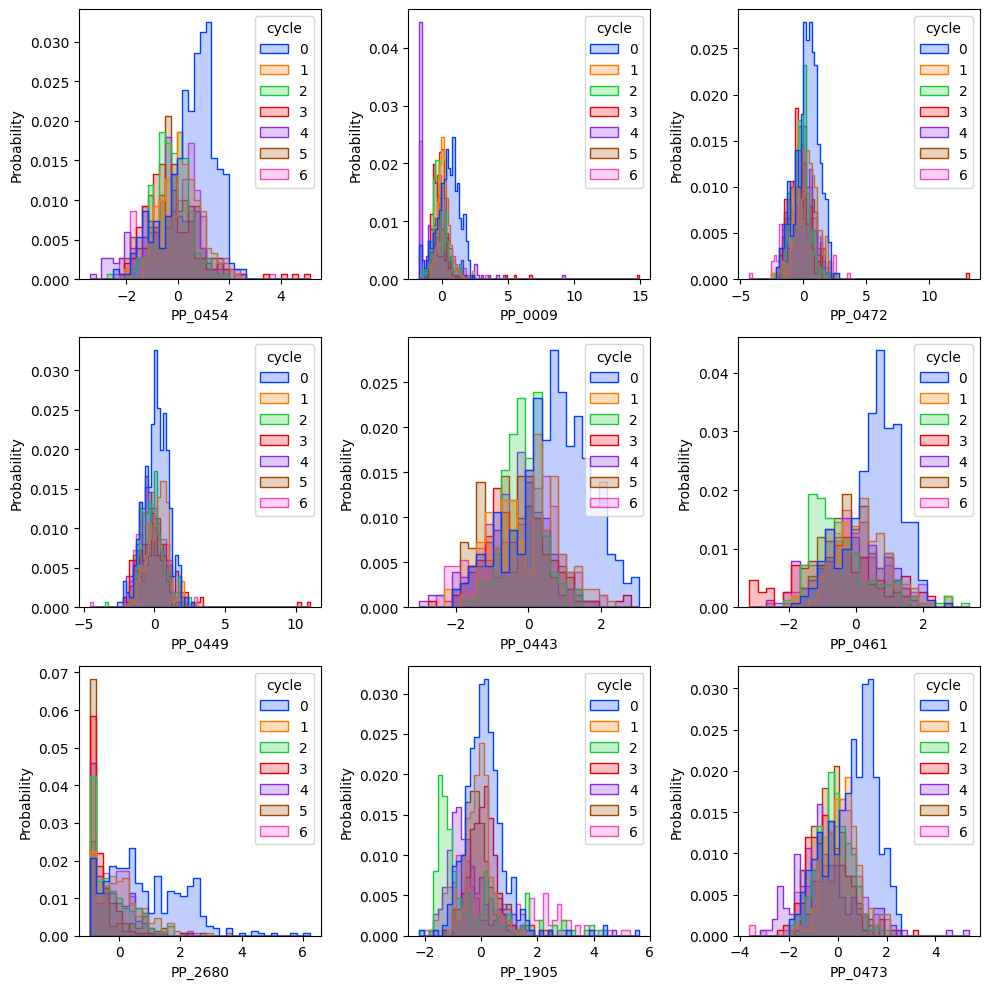

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize = (10,10))

for idx, axis in enumerate(fig.axes):
    sns.histplot(df_top10pcs, x = top_10_pc1.iloc[idx], hue = 'cycle', ax = axis, stat='probability', common_bins = True, element = 'step', palette='bright')
fig.tight_layout()

## Nonlinear dimensionality reduction - TSNE
t-SNE is a nonlinear dimensionality reduction technique. We can use it to ask the same questions as PCA.

In [24]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2, learning_rate='auto', init = 'random', perplexity = 10).fit_transform(X_norm)


### Plot tSNE results
Note that high-titer strains (top-left plot, light green/yellow points) appear in multiple clusters. 

The controls also cluster together really nicely (bottom right graph)

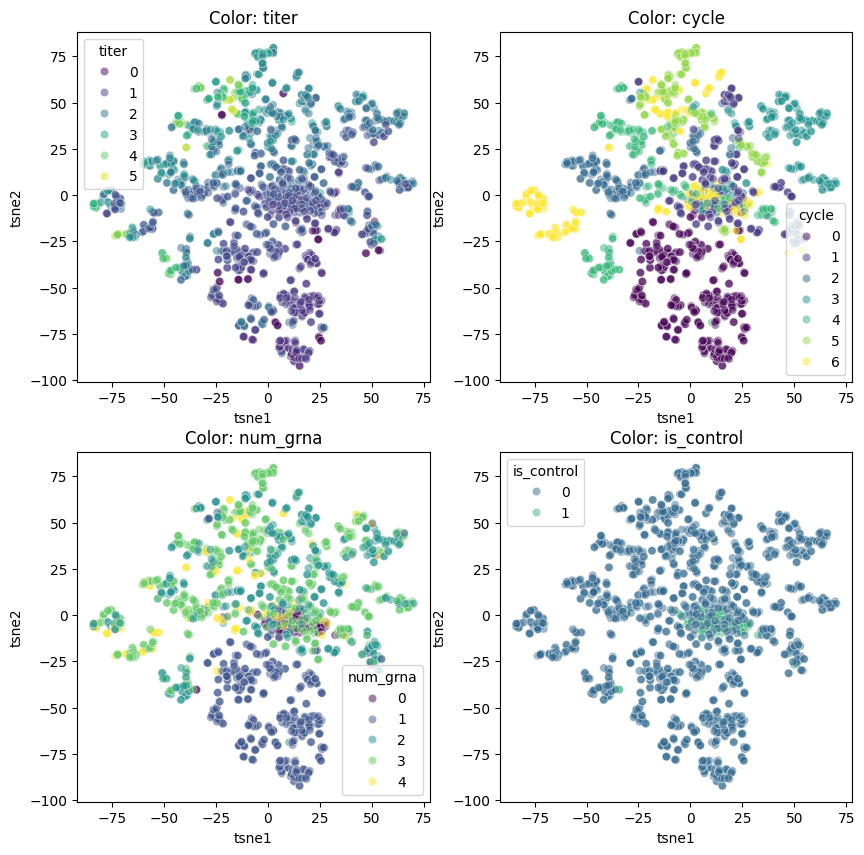

In [25]:
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(tsne1 = X_tsne[:,0], tsne2 = X_tsne[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'tsne1', y = 'tsne2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

#### Varying t-SNE perplexity
There is a hyperparameter for t-SNE - perplexity - that determines how the dimensionality reduction works. Our key observation - that high-titer strains don't all cluster together - seems to be robust to changing perplexity.

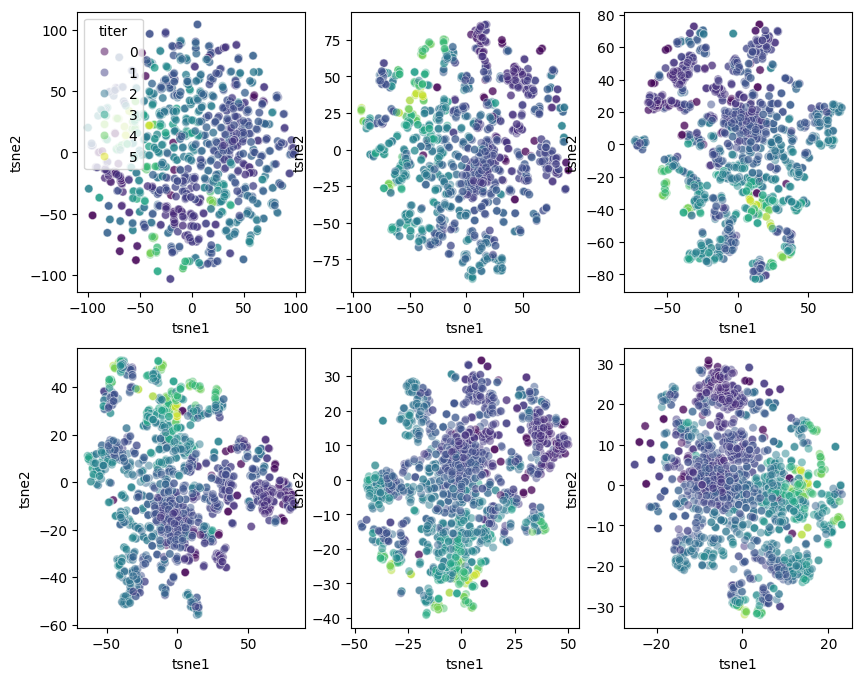

In [26]:
perplexity_vector = [2,5,10,20,50,100]
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10,8))
for i, ax in enumerate(fig.get_axes()):
    X_tsne = TSNE(n_components=2, learning_rate='auto', init = 'random',
                  perplexity = perplexity_vector[i]).fit_transform(X_norm)

    df_plot = pd.DataFrame(dict(tsne1 = X_tsne[:,0], tsne2 = X_tsne[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))
    sns.scatterplot(df_plot, x = 'tsne1', y = 'tsne2', hue = 'titer', palette = 'viridis', ax = ax, alpha = 0.5)
    axis.set_title(f'Perplexity = {perplexity_vector[i]}')
    if i != 0:
        ax.legend([],[], frameon=False)

### Spectral embedding
These are other dimensionality reduction techniques - not super useful I think.

```
>>> from sklearn.datasets import load_digits
>>> from sklearn.manifold import SpectralEmbedding
>>> X, _ = load_digits(return_X_y=True)
>>> X.shape
(1797, 64)
>>> embedding = SpectralEmbedding(n_components=2)
>>> X_transformed = embedding.fit_transform(X[:100])
>>> X_transformed.shape
(100, 2)
```

In [27]:
from sklearn.manifold import SpectralEmbedding, Isomap


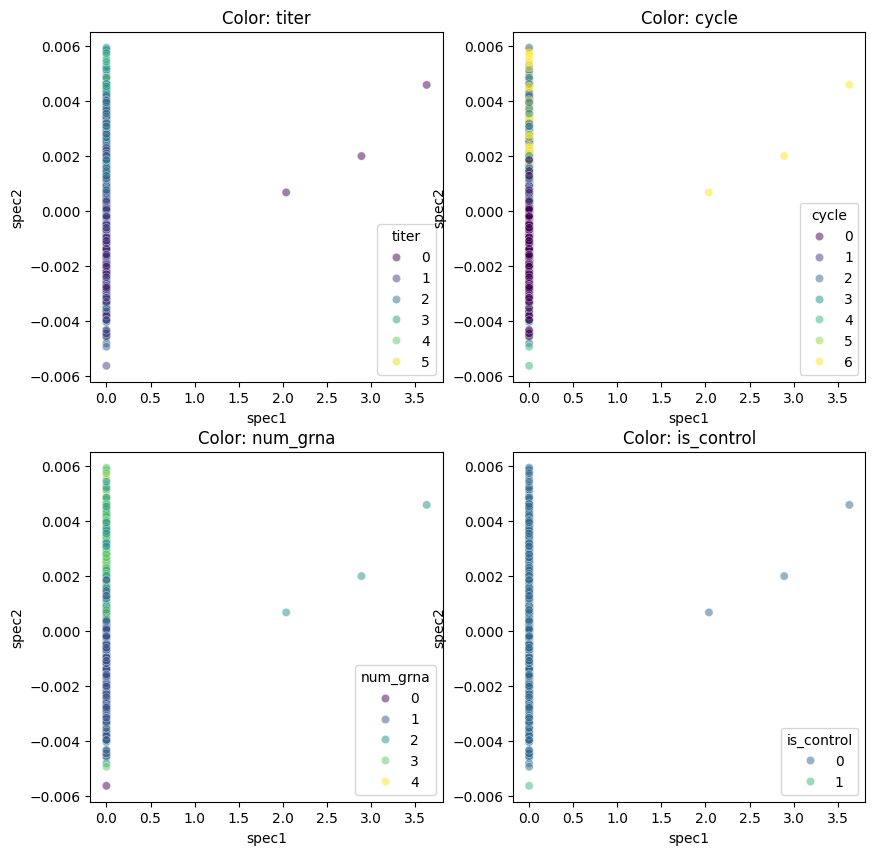

In [28]:
X_spec = SpectralEmbedding(n_components=2,affinity='rbf').fit_transform(X_norm)
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(spec1 = X_spec[:,0], spec2 = X_spec[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'spec1', y = 'spec2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

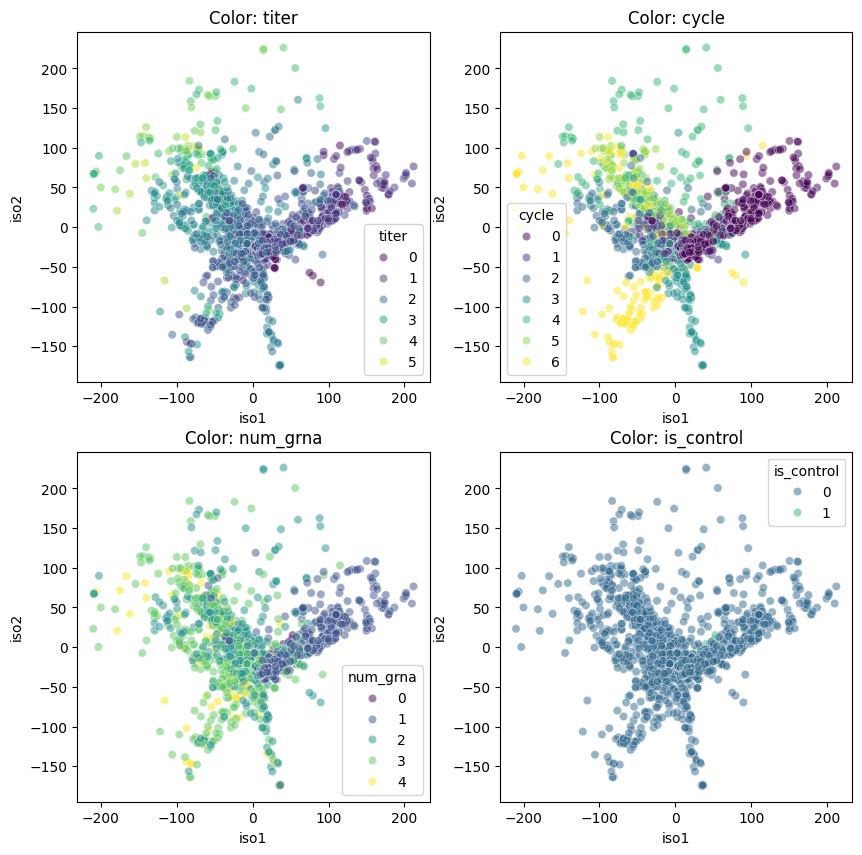

In [29]:
X_iso = Isomap(n_components=2).fit_transform(X_norm)
fig, ax = plt.subplots(nrows=2, ncols = 2, figsize = (10,10))
df_plot = pd.DataFrame(dict(iso1 = X_iso[:,0], iso2 = X_iso[:, 1], titer = y, cycle = cycle_label, num_grna = num_grna, is_control = is_control))

c_lbls = ['titer', 'cycle', 'num_grna', 'is_control']
for idx, axis in enumerate(fig.get_axes()):
    sns.scatterplot(df_plot, x = 'iso1', y = 'iso2', hue = c_lbls[idx], palette = 'viridis', ax = axis, alpha = 0.5)
    axis.set_title(f'Color: {c_lbls[idx]}')

## Distance distributions

After showing that high-titer strains are distant from one another using dimensionality reduction, now we look at the actual distribution of distances.

Look at the distance between all strains, high-titer strains, all strains to controls, and high-titer strains to controls

Use argpartition to get highest titers

In [30]:
N_HIGH = 30
n_high = N_HIGH

In [31]:
high_idx = np.argpartition(y, -n_high)[-n_high:]
high_values = y[high_idx]
high_idx

/tmp/ipykernel_19767/916927881.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values = y[high_idx]


array([416, 176, 428, 181, 415, 266, 761, 921, 215, 174, 175, 217, 759,
       183, 427, 670, 182, 381, 596, 382, 595, 383, 387, 594, 389, 393,
       394, 395, 213, 388])

In [32]:
from scipy.spatial.distance import squareform, pdist

In [33]:
len(is_control)
X_norm.shape

(1506, 1645)

Text(0.5, 0, 'Distribution of proteomics distances between strains')

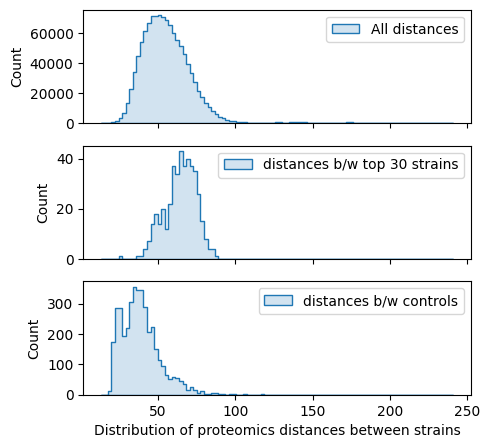

In [34]:
d_all = pdist(X_norm)
d_top = pdist(X_norm[high_idx,:])
d_ctrl = pdist(X_norm[np.where(is_control)[0],:])
bins = np.linspace(0.8*d_all.min(), 1.2*d_all.max(), 100)
fig, ax = plt.subplots(figsize = (5,5), nrows = 3, sharex = True)
sns.histplot(data=d_all, stat = 'count', bins=bins, alpha = 0.2, label = 'All distances', ax = ax[0], element = 'step')
sns.histplot(data = d_top, stat = 'count', bins = bins, alpha = 0.2, label = f'distances b/w top {n_high} strains', ax = ax[1], element = 'step')
sns.histplot(data = d_ctrl, stat = 'count', bins = bins, alpha = 0.2, label = f'distances b/w controls', ax = ax[2], element = 'step')
for a in ax:
    a.legend()
ax[-1].set_xlabel('Distribution of proteomics distances between strains')
# plt.legend(['All distances', f'distances b/w top {n_high} strains'])


### Distance distribution heatmap
Make a heatmap showing the distances between all of the high-titer strains (and including a few controls).

Observations: 

- All the controls cluster together (good).
- Replicates don't necessarily cluster together (messy).
- There are maybe 4 clusters and a few random individuals within the data.

/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


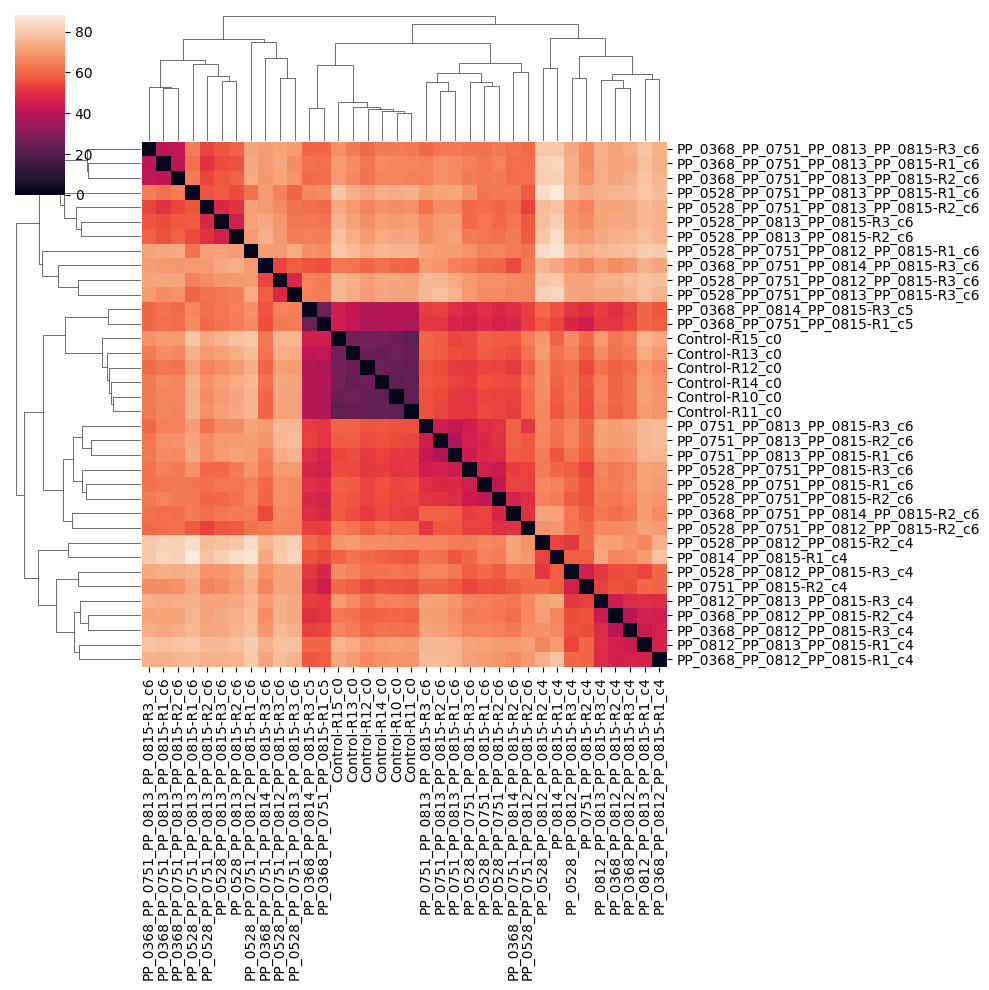

In [35]:
control_idx = np.where(is_control)[0][:6]
plot_idx = np.hstack([control_idx, high_idx])
# plot_idx = high_idx
high_dmat = squareform(pdist(X_norm[plot_idx,:]))
high_dist_df = pd.DataFrame(data = high_dmat, columns = X.index.values[plot_idx], index = X.index.values[plot_idx])
sns.clustermap(data = high_dist_df)

### Repeat heatmap with replicate-averaged data

/tmp/ipykernel_19767/4132844317.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


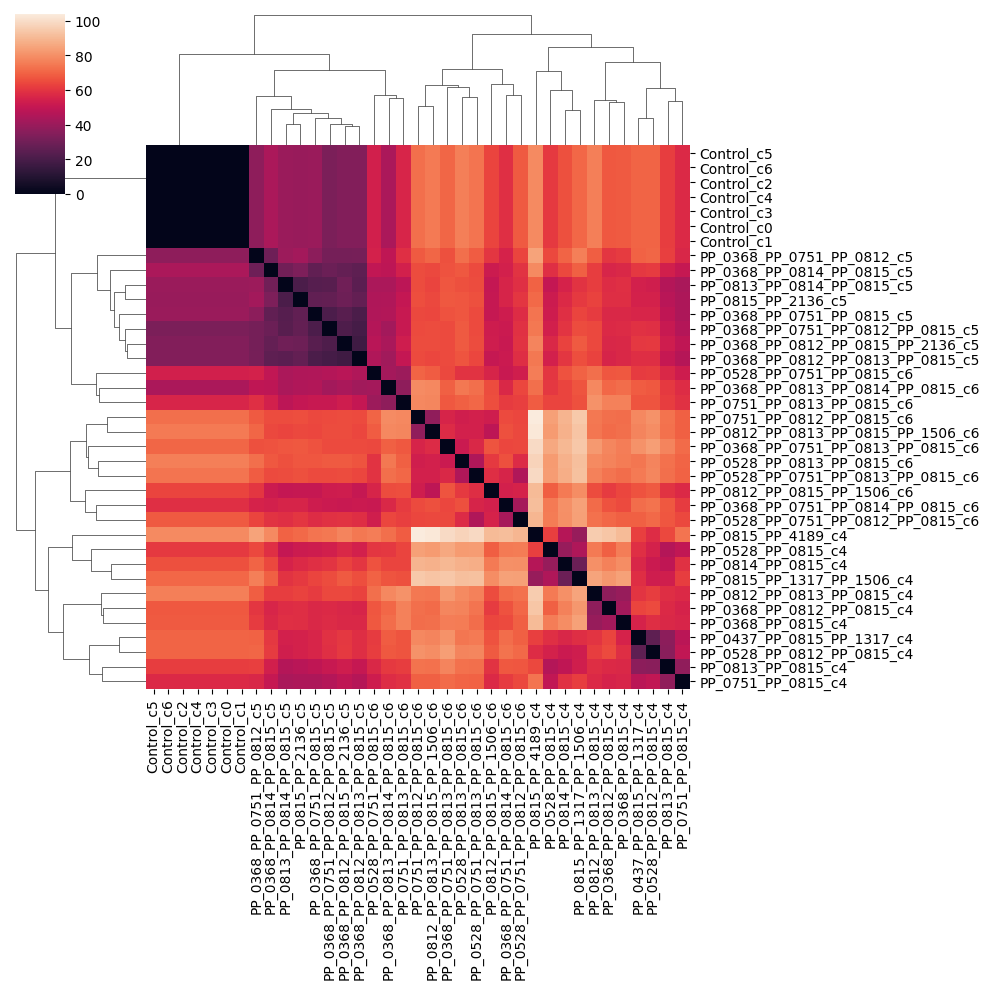

In [36]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
# plot_idx = high_idx
high_dmat = squareform(pdist(X_mean_norm[plot_idx,:]))


high_dist_df = pd.DataFrame(data = high_dmat, columns = X_mean.index.values[plot_idx], index = X_mean.index.values[plot_idx])
sns.clustermap(data = high_dist_df)



## Coloring my data by titer-category

Can add a color to each row/column in the clustergram indicating some other variable - here I'll use titer

### First, get data
Pick `n_high` highest titer strains controls and get their idx

In [37]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]
print(f'idx of high titer: {high_idx}')

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
high_dmat = squareform(pdist(X_mean_norm[plot_idx,:]))

idx of high titer: [416 176 428 181 415 266 761 921 215 174 175 217 759 183 427 670 182 381
 596 382 595 383 387 594 389 393 394 395 213 388]


/tmp/ipykernel_19767/586437896.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]


In [38]:
control_idx

array([0, 1, 2, 3, 4, 5])

In [39]:
control_idx_mean

array([0, 1, 2, 3, 4, 5, 6])

/tmp/ipykernel_19767/2770640960.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/tmp/ipykernel_19767/2770640960.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.axvline(np.mean(y_mean[control_idx_mean]), c = 'r', linestyle = '--', label = 'Control')


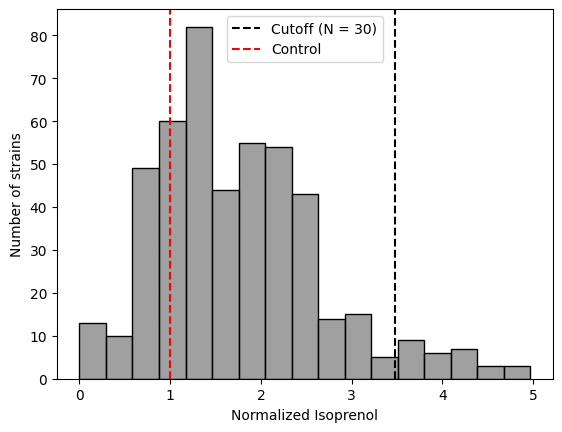

In [40]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

fig, ax = plt.subplots()
sns.histplot(
    data = y_mean,
    ax = ax,
    color = 'grey' 
)
ax.set_xlabel('Normalized Isoprenol')
ax.set_ylabel('Number of strains')
ax.axvline(np.min(high_values_mean), c= 'k', linestyle = '--', label = f'Cutoff (N = {N_HIGH})')
ax.axvline(np.mean(y_mean[control_idx_mean]), c = 'r', linestyle = '--', label = 'Control')
ax.legend()

In [ ]:
import matplotlib as mpl
from matplotlib import cm

/tmp/ipykernel_19767/731110976.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/tmp/ipykernel_19767/731110976.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  titer_category_df = pd.DataFrame(y_mean[plot_idx])
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non

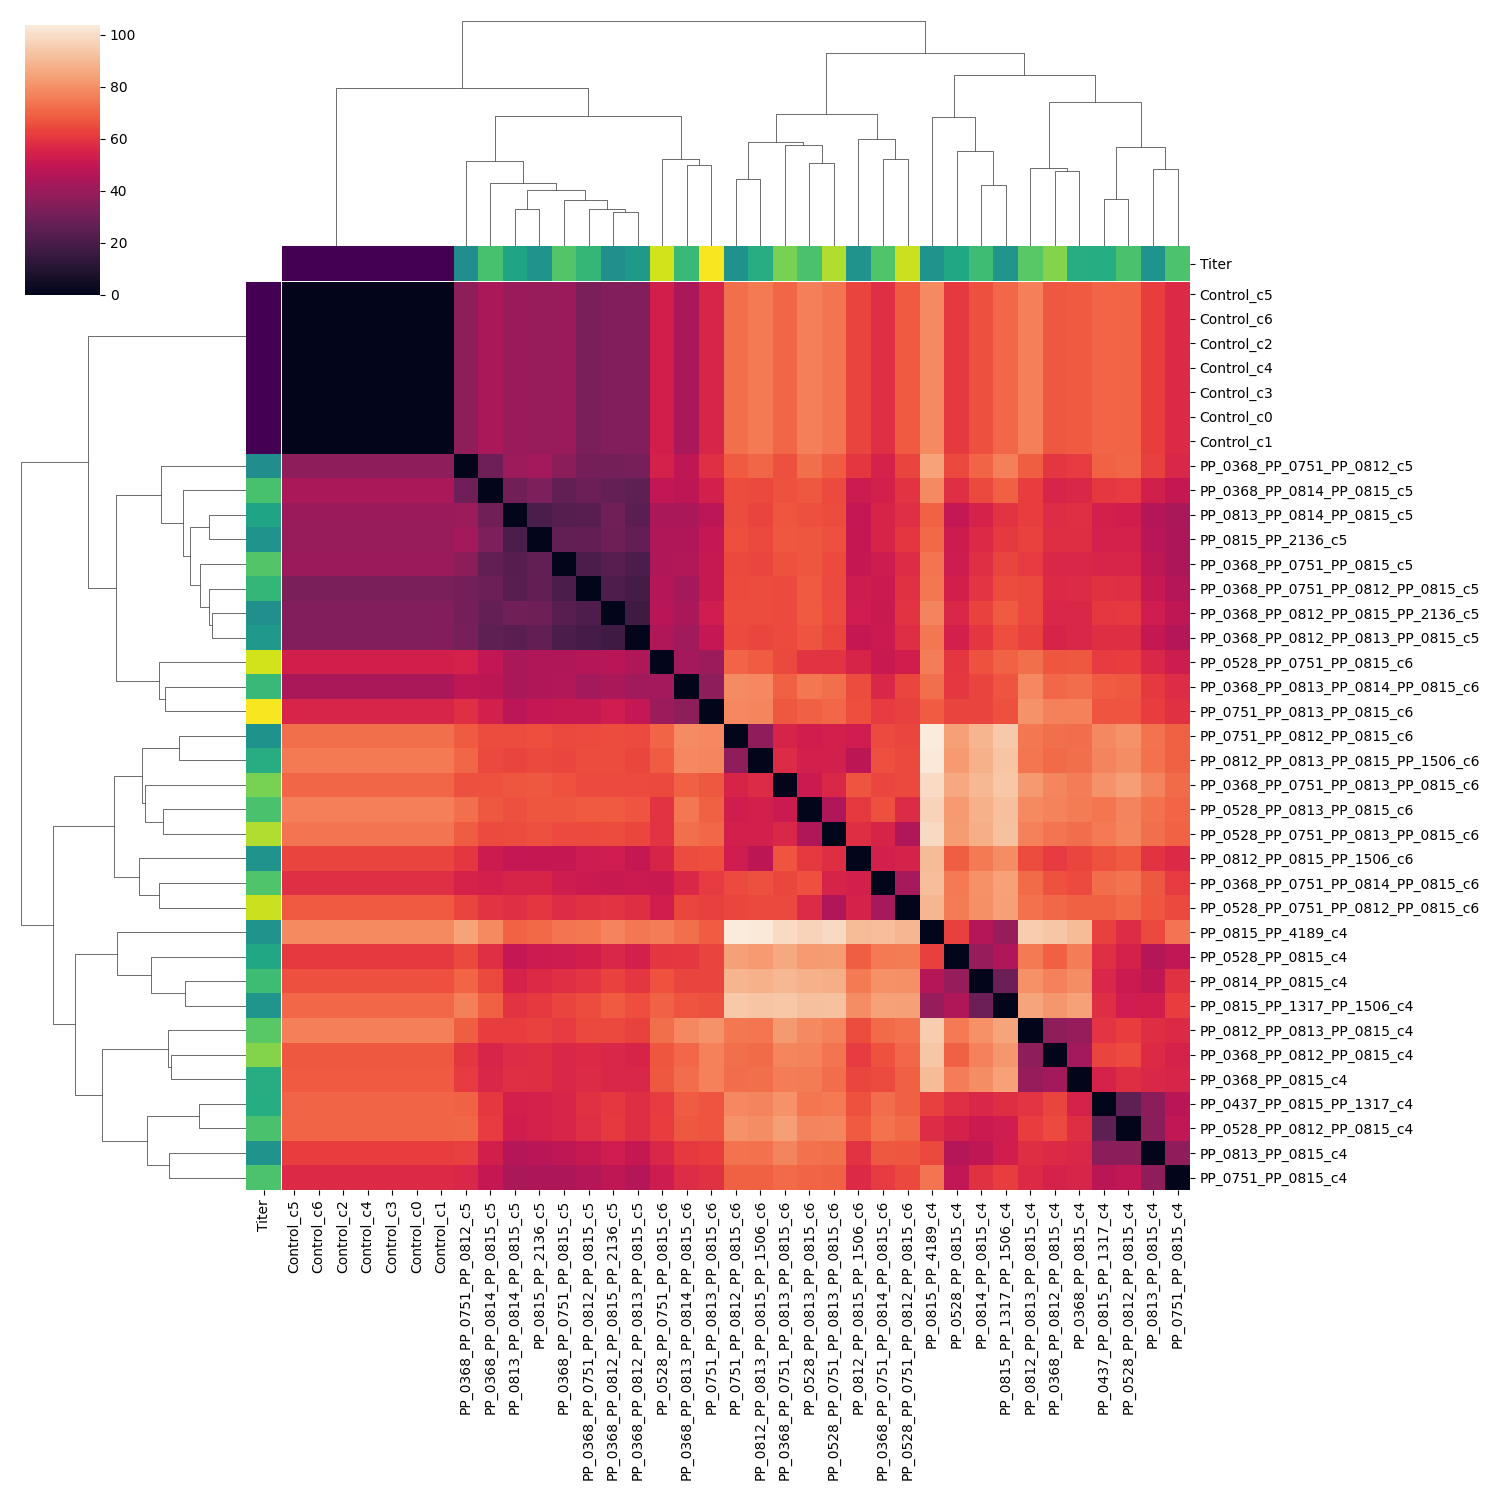

In [ ]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
high_dmat_compressed = pdist(X_mean_norm[plot_idx,:])
high_dmat = squareform(high_dmat_compressed)

titer_category_df = pd.DataFrame(y_mean[plot_idx])

scalar_map = cm.ScalarMappable(
    norm = mpl.colors.Normalize(vmin =2, vmax = 5),
    cmap = plt.get_cmap('viridis'),
)

titer_category_df.loc[:,'c_cont'] = titer_category_df['isoprenol'].apply(lambda x: scalar_map.to_rgba(x))
titer_colors = pd.Series(titer_category_df.loc[:,'c_cont'])
titer_colors.name = 'Titer'

high_dist_df = pd.DataFrame(data = high_dmat, columns = X_mean.index.values[plot_idx], index = X_mean.index.values[plot_idx])
c = sns.clustermap(
    data = high_dist_df,
    row_colors = titer_colors, 
    col_colors=titer_colors,
    figsize=(15,15)
)

## Replicate clustering
Here, I expand the funcitonality of the code by creating my own distance linkage (using scipy builtins) - therefore I can work with the clustering after I make the plot.

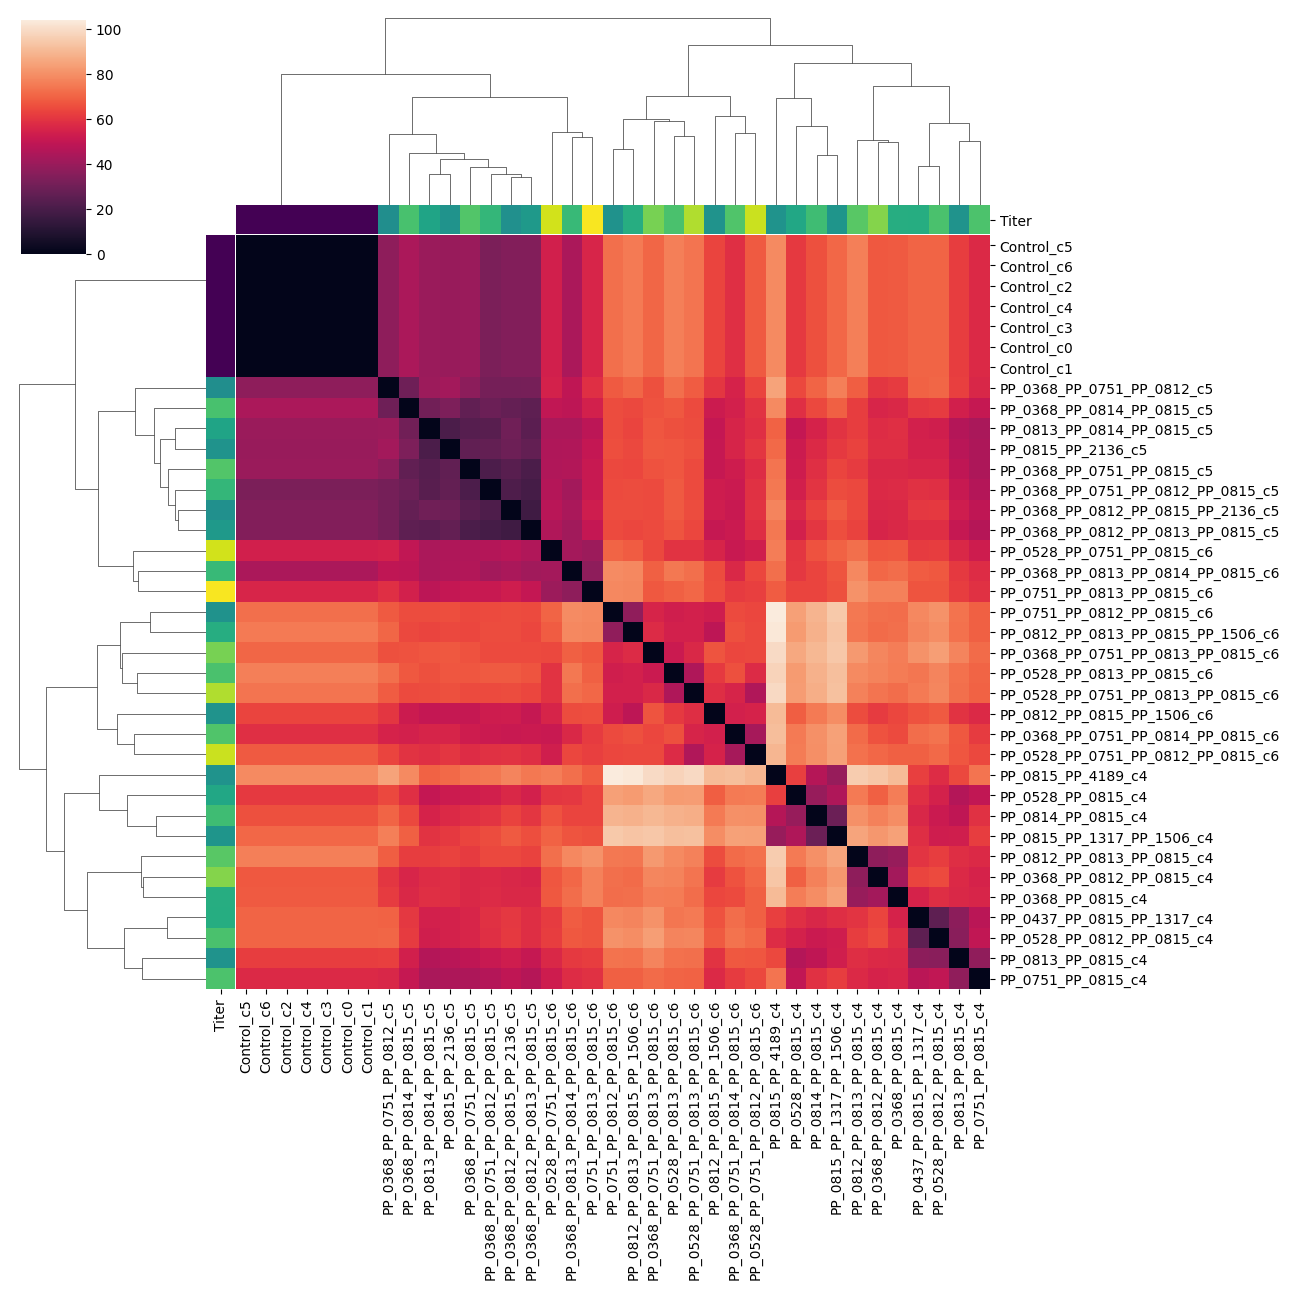

In [43]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

dist_linkage = hierarchy.linkage(
    distance.pdist(high_dist_df), method='average')

sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=titer_colors,
               method="average",
               col_colors=titer_colors,
               figsize=(13, 13)
              )

### Demonstrate that clustering works
Here I color each strain by the assigned cluster to check that it's working.

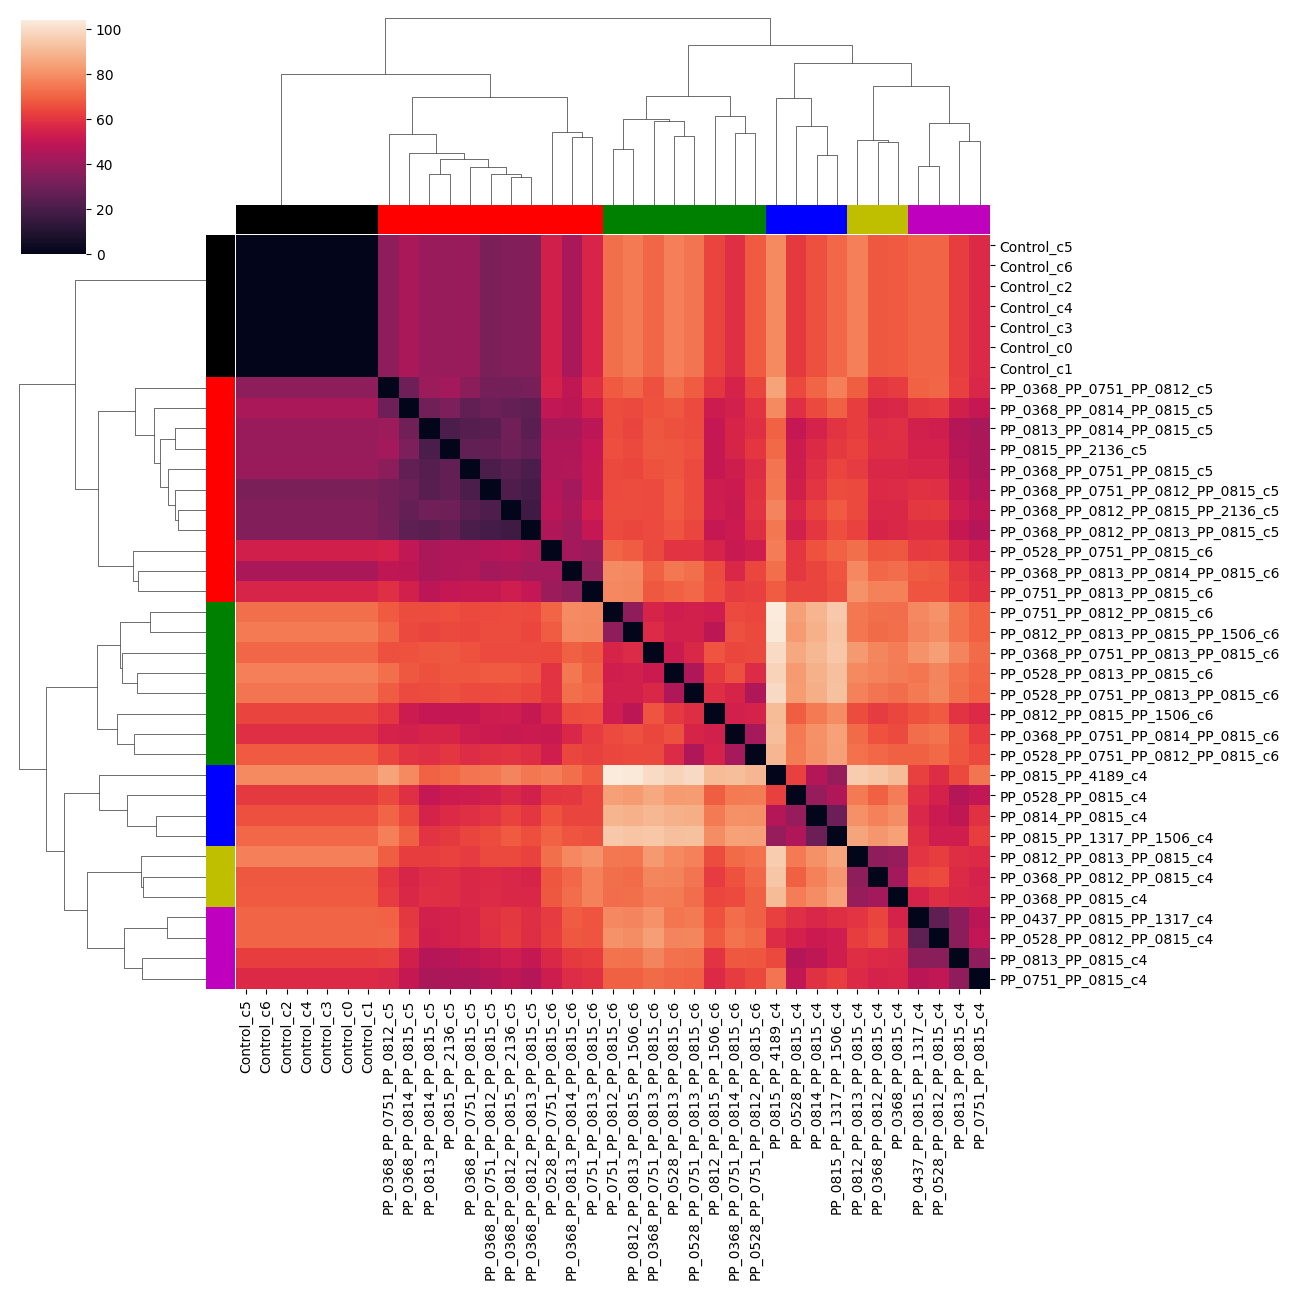

In [44]:
fc = hierarchy.fcluster(dist_linkage, t = 6, criterion='maxclust')
fc
c_all = 'krgbym'
fc_color = [c_all[int(x-1)] for x in fc]
sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=fc_color,
               method="average",
               col_colors=fc_color,
               figsize=(13, 13)
              )

### Do PCA on clustered high-titer strains

In [188]:
cluster_df = high_dist_df.copy()
cluster_df['cluster'] = fc

In [46]:
X_cluster_df = X_mean_norm_df.iloc[plot_idx,:].copy()
X_cluster_df['cluster'] = cluster_df['cluster']
X_cluster_df['isoprenol'] = pd.Series(y_mean[plot_idx])
X_cluster_df

/tmp/ipykernel_19767/685606278.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  X_cluster_df['isoprenol'] = pd.Series(y_mean[plot_idx])


MM_1762   PP_0001   PP_0002   PP_0003  \
line_name                                                                    
Control_c0                         -0.179119  0.073632  0.467729  0.197197   
Control_c1                         -0.179119  0.073632  0.467729  0.197197   
Control_c2                         -0.179119  0.073632  0.467729  0.197197   
Control_c3                         -0.179119  0.073632  0.467729  0.197197   
Control_c4                         -0.179119  0.073632  0.467729  0.197197   
Control_c5                         -0.179119  0.073632  0.467729  0.197197   
Control_c6                         -0.179119  0.073632  0.467729  0.197197   
PP_0368_PP_0751_PP_0812_c5          0.651027 -0.535265  0.673861  4.272333   
PP_0368_PP_0812_PP_0815_PP_2136_c5  1.538495  0.293503  0.046839  0.882546   
PP_0751_PP_0812_PP_0815_c6          1.229221 -0.677700  0.425525  0.814926   
PP_0812_PP_0815_PP_1506_c6          1.548710 -0.494461  1.619482  0.277204   
PP_0368_PP_0813_PP_0814_PP_0815_c6  0.364260 -1.084068 -1.924163  1.506589   
PP_0813_PP_0814_PP_0815_c5          0.886037 -1.228399 -0.193671  0.035896   
PP_0368_PP_0751_PP_0815_c5          1.005683 -0.510961 -1.354842  0.471391   
PP_0812_PP_0813_PP_0815_PP_1506_c6  1.791144  0.876191  0.296527  1.233094   
PP_0813_PP_0815_c4                  1.487393 -0.585231 -1.943592 -0.871267   
PP_0437_PP_0815_PP_1317_c4          0.795630 -1.142439 -1.033681 -0.562869   
PP_0368_PP_0751_PP_0812_PP_0815_c5  1.058287 -0.474319 -0.323894 -0.019098   
PP_0368_PP_0812_PP_0815_c4          3.188254  1.559486  0.760946  0.479062   
PP_0814_PP_0815_c4                 -0.483066 -1.610065 -1.476985 -2.546109   
PP_0528_PP_0813_PP_0815_c6          1.601055 -0.591033 -1.985169  0.002830   
PP_0812_PP_0813_PP_0815_c4          2.932593  1.427627  1.038168  0.619172   
PP_0815_PP_1317_PP_1506_c4         -0.574019 -2.746052 -1.692611 -2.635622   
PP_0528_PP_0815_c4                  1.341730 -1.667334 -1.802722 -2.499671   
PP_0751_PP_0813_PP_0815_c6          0.038892 -0.892758 -1.926184 -0.669993   
PP_0528_PP_0812_PP_0815_c4          1.270998 -0.985761 -1.812225 -0.952580   
PP_0751_PP_0815_c4                  1.368797 -0.881495 -1.319191 -0.513493   
PP_0368_PP_0751_PP_0813_PP_0815_c6  1.062510  1.033162 -1.994385  0.892776   
PP_0815_PP_2136_c5                  1.850638 -1.399083 -0.440453  0.072627   
PP_0528_PP_0751_PP_0815_c6          0.990888 -1.481244 -1.855784  0.167685   
PP_0815_PP_4189_c4                 -1.075181 -2.422600 -2.000410 -2.779027   
PP_0368_PP_0812_PP_0813_PP_0815_c5  1.149258 -0.347153 -0.434565  0.446170   
PP_0368_PP_0751_PP_0814_PP_0815_c6  1.176170 -0.057094 -0.910622  1.431736   
PP_0528_PP_0751_PP_0813_PP_0815_c6  1.170564 -0.793223 -1.129106  0.642364   
PP_0528_PP_0751_PP_0812_PP_0815_c6  1.020552 -0.808162 -1.088098  0.677478   
PP_0368_PP_0815_c4                  2.015898  1.896261  1.348090  0.638922   
PP_0368_PP_0814_PP_0815_c5          0.974576 -0.367182  0.066949  3.143599   

                                     PP_0004   PP_0005   PP_0006   PP_0009  \
line_name                                                                    
Control_c0                          0.240575 -0.288097  0.231010  0.532455   
Control_c1                          0.240575 -0.288097  0.231010  0.532455   
Control_c2                          0.240575 -0.288097  0.231010  0.532455   
Control_c3                          0.240575 -0.288097  0.231010  0.532455   
Control_c4                          0.240575 -0.288097  0.231010  0.532455   
Control_c5                          0.240575 -0.288097  0.231010  0.532455   
Control_c6                          0.240575 -0.288097  0.231010  0.532455   
PP_0368_PP_0751_PP_0812_c5         -0.163412 -0.036797  1.603280 -0.212994   
PP_0368_PP_0812_PP_0815_PP_2136_c5 -0.341753 -0.600882 -0.242918 -0.337973   
PP_0751_PP_0812_PP_0815_c6          0.064905 -1.035530 -0.182168 -0.854038   
PP_0812_PP_0815_PP_1506_c6         -0.552149  3.466032 -1.

In [47]:
X_cluster_results_df = X_cluster_df.loc[X_cluster_df['isoprenol']>1.05, ['cluster', 'isoprenol']].sort_values(['cluster', 'isoprenol'], ascending = [True, False]).copy(deep = True)
X_cluster_results_df['to_make'] = False
for c in X_cluster_results_df['cluster'].unique():
    idx  = X_cluster_results_df['cluster'].values == c
    top2 = X_cluster_results_df.loc[idx].sort_values('isoprenol', ascending = False).head(2).index
    X_cluster_results_df.loc[top2, 'to_make'] = True 

In [48]:
X_cluster_results_df[X_cluster_results_df['to_make']]

cluster  isoprenol  to_make
line_name                                                      
PP_0751_PP_0813_PP_0815_c6                2   4.968972     True
PP_0528_PP_0751_PP_0815_c6                2   4.791595     True
PP_0528_PP_0751_PP_0812_PP_0815_c6        3   4.762459     True
PP_0528_PP_0751_PP_0813_PP_0815_c6        3   4.636974     True
PP_0814_PP_0815_c4                        4   4.067830     True
PP_0528_PP_0815_c4                        4   3.791392     True
PP_0368_PP_0812_PP_0815_c4                5   4.447537     True
PP_0812_PP_0813_PP_0815_c4                5   4.216550     True
PP_0751_PP_0815_c4                        6   4.152019     True
PP_0528_PP_0812_PP_0815_c4                6   4.135586     True

In [49]:
X_cluster_results_df[X_cluster_results_df['to_make']].to_csv('cluster_results_to_make.csv')

In [50]:
X_cluster_df.loc[X_cluster_df['isoprenol']>1.05, ['cluster', 'isoprenol']].sort_values(['cluster', 'isoprenol'], ascending = [True, False])

cluster  isoprenol
line_name                                             
PP_0751_PP_0813_PP_0815_c6                2   4.968972
PP_0528_PP_0751_PP_0815_c6                2   4.791595
PP_0368_PP_0751_PP_0815_c5                2   4.180161
PP_0368_PP_0814_PP_0815_c5                2   4.122336
PP_0368_PP_0813_PP_0814_PP_0815_c6        2   4.020830
PP_0368_PP_0751_PP_0812_PP_0815_c5        2   3.992067
PP_0813_PP_0814_PP_0815_c5                2   3.750287
PP_0368_PP_0812_PP_0813_PP_0815_c5        2   3.611919
PP_0815_PP_2136_c5                        2   3.544849
PP_0368_PP_0812_PP_0815_PP_2136_c5        2   3.497841
PP_0368_PP_0751_PP_0812_c5                2   3.473659
PP_0528_PP_0751_PP_0812_PP_0815_c6        3   4.762459
PP_0528_PP_0751_PP_0813_PP_0815_c6        3   4.636974
PP_0368_PP_0751_PP_0813_PP_0815_c6        3   4.386927
PP_0368_PP_0751_PP_0814_PP_0815_c6        3   4.178500
PP_0528_PP_0813_PP_0815_c6                3   4.141056
PP_0812_PP_0813_PP_0815_PP_1506_c6        3   3.870616
PP_0812_PP_0815_PP_1506_c6                3   3.538733
PP_0751_PP_0812_PP_0815_c6                3   3.514168
PP_0814_PP_0815_c4                        4   4.067830
PP_0528_PP_0815_c4                        4   3.791392
PP_0815_PP_1317_PP_1506_c4                4   3.567687
PP_0815_PP_4189_c4                        4   3.542608
PP_0368_PP_0812_PP_0815_c4                5   4.447537
PP_0812_PP_0813_PP_0815_c4                5   4.216550
PP_0368_PP_0815_c4                        5   3.869530
PP_0751_PP_0815_c4                        6   4.152019
PP_0528_PP_0812_PP_0815_c4                6   4.135586
PP_0437_PP_0815_PP_1317_c4                6   3.856131
PP_0813_PP_0815_c4                        6   3.544623

<Axes: xlabel='isoprenol', ylabel='cluster'>

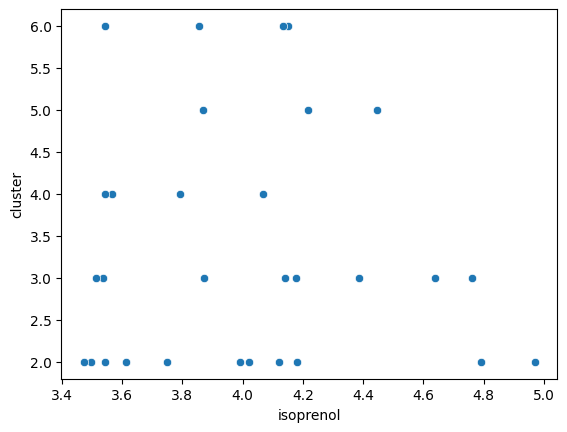

In [51]:
sns.scatterplot(
    data = X_cluster_df[X_cluster_df['isoprenol']>1.1].sort_values('isoprenol', ascending = False),
    x = 'isoprenol',
    y = 'cluster',
)

In [52]:
sns.stripplot(
    data = X_cluster_df[X_cluster_df['isoprenol']>1.1].sort_values('isoprenol', ascending = False),
    y = 'isoprenol',
    x = 'cluster'
)
plt.gca().axhline(1)

In [53]:
X_cluster_df['cluster'].sort_values()

line_name
Control_c0                            1
Control_c1                            1
Control_c2                            1
Control_c3                            1
Control_c4                            1
Control_c5                            1
Control_c6                            1
PP_0368_PP_0812_PP_0813_PP_0815_c5    2
PP_0528_PP_0751_PP_0815_c6            2
PP_0815_PP_2136_c5                    2
PP_0751_PP_0813_PP_0815_c6            2
PP_0368_PP_0751_PP_0812_PP_0815_c5    2
PP_0368_PP_0751_PP_0815_c5            2
PP_0368_PP_0814_PP_0815_c5            2
PP_0368_PP_0813_PP_0814_PP_0815_c6    2
PP_0368_PP_0751_PP_0812_c5            2
PP_0813_PP_0814_PP_0815_c5            2
PP_0368_PP_0812_PP_0815_PP_2136_c5    2
PP_0812_PP_0813_PP_0815_PP_1506_c6    3
PP_0528_PP_0751_PP_0812_PP_0815_c6    3
PP_0528_PP_0751_PP_0813_PP_0815_c6    3
PP_0368_PP_0751_PP_0814_PP_0815_c6    3
PP_0528_PP_0813_PP_0815_c6            3
PP_0812_PP_0815_PP_1506_c6            3
PP_0368_PP_0751_PP_0813_PP_081

In [54]:
import re
from collections import Counter

In [55]:
test = 'PP_0528_PP_0815_PP_1317_c3'
re.findall('PP_[0-9]{4}', test)
# test.split('_')[:-1]

['PP_0528', 'PP_0815', 'PP_1317']

In [56]:
cluster_df_target = X_cluster_df['cluster'].sort_values().copy().reset_index(drop = False)
cluster_df_target['is_control'] = cluster_df_target['line_name'].apply(lambda x: 'ontrol' in x)

cluster_df_target

n_clusters = cluster_df_target['cluster'].max()
target_cluster_list = [[] for _ in range(n_clusters)]
for idx, srs in cluster_df_target.iterrows():
    cluster = srs['cluster']
    targets = re.findall('PP_[0-9]{4}', srs['line_name'])
    [target_cluster_list[cluster-1].append(target) for target in targets]

counted_targets = [Counter(cluster_list) for cluster_list in target_cluster_list]
counted_targets

[Counter(),
 Counter({'PP_0815': 10,
          'PP_0368': 7,
          'PP_0751': 5,
          'PP_0812': 4,
          'PP_0813': 4,
          'PP_0814': 3,
          'PP_2136': 2,
          'PP_0528': 1}),
 Counter({'PP_0815': 8,
          'PP_0751': 5,
          'PP_0812': 4,
          'PP_0813': 4,
          'PP_0528': 3,
          'PP_1506': 2,
          'PP_0368': 2,
          'PP_0814': 1}),
 Counter({'PP_0815': 4,
          'PP_0814': 1,
          'PP_1317': 1,
          'PP_1506': 1,
          'PP_0528': 1,
          'PP_4189': 1}),
 Counter({'PP_0815': 3, 'PP_0368': 2, 'PP_0812': 2, 'PP_0813': 1}),
 Counter({'PP_0815': 4,
          'PP_0437': 1,
          'PP_1317': 1,
          'PP_0813': 1,
          'PP_0751': 1,
          'PP_0528': 1,
          'PP_0812': 1})]

In [57]:
pd.DataFrame.from_dict(counted_targets[2], orient = 'index')

0
PP_0812  4
PP_0813  4
PP_0815  8
PP_1506  2
PP_0528  3
PP_0751  5
PP_0368  2
PP_0814  1

/tmp/ipykernel_19767/227182286.py:8: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(data = ct_df, x = 'counts', y = 'target', hue = 'cluster', palette = sns.color_palette('tab10'))


<Axes: xlabel='counts', ylabel='target'>

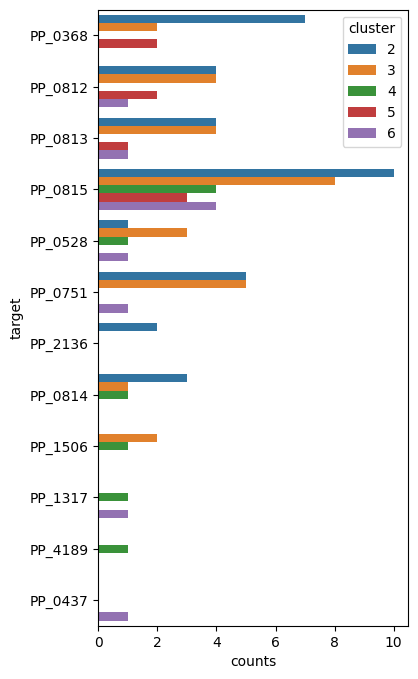

In [58]:
ct_df_list = []
for i, c in enumerate(counted_targets):
    ct_df_list.append(pd.DataFrame.from_dict(c, orient = 'index', columns=['counts']).reset_index(names = ['target']))
    ct_df_list[i]['cluster'] = i
ct_df = pd.concat(ct_df_list)
ct_df['cluster'] +=1
fig, ax = plt.subplots(figsize = (4,8))
sns.barplot(data = ct_df, x = 'counts', y = 'target', hue = 'cluster', palette = sns.color_palette('tab10'))

<Axes: xlabel='counts', ylabel='index'>

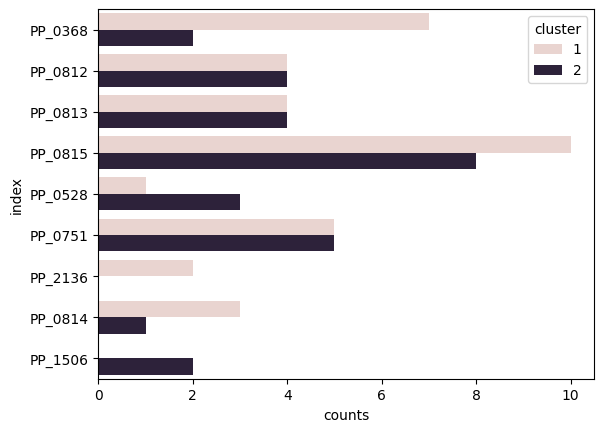

In [59]:
test = pd.DataFrame.from_dict(counted_targets[1], orient = 'index', columns=['counts']).reset_index()
test['cluster'] = 1
test2 = pd.DataFrame.from_dict(counted_targets[2], orient = 'index', columns=['counts']).reset_index()
test2['cluster'] = 2
test_both = pd.concat([test, test2])
test_both
sns.barplot(data = test_both, x = 'counts', y = 'index', hue = 'cluster')

### Do PCA and color by cluster/titer

In [60]:
pca = PCA(n_components = 10)
cluster_pca = pca.fit_transform(X_cluster_df.loc[:,protein_measurements])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
legend1 = ax.legend(*sc.legend_elements(), loc = 'upper left', title = 'Clusters')
ax.add_artist(legend1)
ax.set_title('Principal components colored by cluster')
text_list = []
for i in range(len(cluster_pca)):
    text = ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))
    text_list.append(text)
adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1))

2 [ 0.55193256 -0.75343248]
3 [-0.56481201 -0.33513121]
4 [ 0.06345618 -0.18453969]
5 [-0.43253479 -0.14280362]
1 [ 0.61866882 -0.14821493]
6 [-0.33811371 -0.72850167]


([Text(2.009839870544397, -28.95344628119922, 'Control_c0'),
  Text(28.150916172112687, -31.605995983436074, 'Control_c1'),
  Text(16.3822828020579, -29.56277484693458, 'Control_c2'),
  Text(30.319396410567506, -29.54630555568015, 'Control_c3'),
  Text(23.979295216510522, -26.910849221300932, 'Control_c4'),
  Text(10.173570428456557, -26.799710244638437, 'Control_c5'),
  Text(13.66636217098501, -31.951980727206095, 'Control_c6'),
  Text(15.728106693861676, -20.565271735118653, 'PP_0368_PP_0751_PP_0812_c5'),
  Text(25.072615280380973, -13.43851912013507, 'PP_0368_PP_0812_PP_0815_PP_2136_c5'),
  Text(-23.725201605240578, 6.817769011279857, 'PP_0751_PP_0812_PP_0815_c6'),
  Text(17.3955435652463, 7.412349704229868, 'PP_0812_PP_0815_PP_1506_c6'),
  Text(30.867482010912227, -15.544334862878287, 'PP_0368_PP_0813_PP_0814_PP_0815_c6'),
  Text(26.38292129181434, 0.15583207774726304, 'PP_0813_PP_0814_PP_0815_c5'),
  Text(28.79140801701756, -6.595486684351307, 'PP_0368_PP_0751_PP_0815_c5'),
  Text

2 [0.08053819 0.25213205]
3 [-0.68331705  0.97627886]
4 [0.30845888 0.86723402]
5 [-0.0239429   0.23543368]
1 [-0.65749239  0.4590901 ]
6 [-0.4090721   0.74522475]


([Text(2.0049733310160036, -29.299431024969245, 'Control_c0'),
  Text(16.986838410114018, -29.43371302492323, 'Control_c1'),
  Text(29.509293327137, -28.72278978535254, 'Control_c2'),
  Text(2.8512730492319065, -26.692482141282987, 'Control_c3'),
  Text(16.452028373678772, -31.49066773551273, 'Control_c4'),
  Text(29.04239534588045, -30.914026495896024, 'Control_c5'),
  Text(18.114251549598265, -26.56308277728244, 'Control_c6'),
  Text(15.728106693861676, -20.565271735118653, 'PP_0368_PP_0751_PP_0812_c5'),
  Text(24.75011834929053, -13.43851912013507, 'PP_0368_PP_0812_PP_0815_PP_2136_c5'),
  Text(-23.725201605240578, 6.817769011279857, 'PP_0751_PP_0812_PP_0815_c6'),
  Text(20.29801594506023, 7.066364960459843, 'PP_0812_PP_0815_PP_1506_c6'),
  Text(30.867482010912227, -15.429006614954943, 'PP_0368_PP_0813_PP_0814_PP_0815_c6'),
  Text(24.447939705271722, 0.15583207774726304, 'PP_0813_PP_0814_PP_0815_c5'),
  Text(30.726389603560165, -7.28745617189135, 'PP_0368_PP_0751_PP_0815_c5'),
  Text

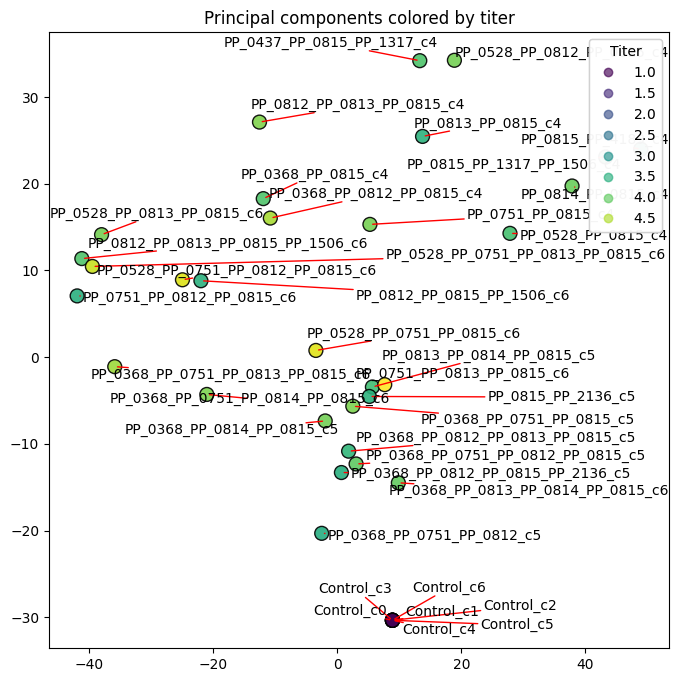

In [61]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['isoprenol'], s = 100, alpha = 0.9, edgecolors='k')
handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Titer")
ax.add_artist(legend2)
ax.set_title('Principal components colored by titer')
text_list = []
for i in range(len(cluster_pca)):
    text = ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))
    text_list.append(text)
adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1))

Text(0.5, 1.0, 'PCA of High-Titer strains does explains\na significant part of the variance in the data')

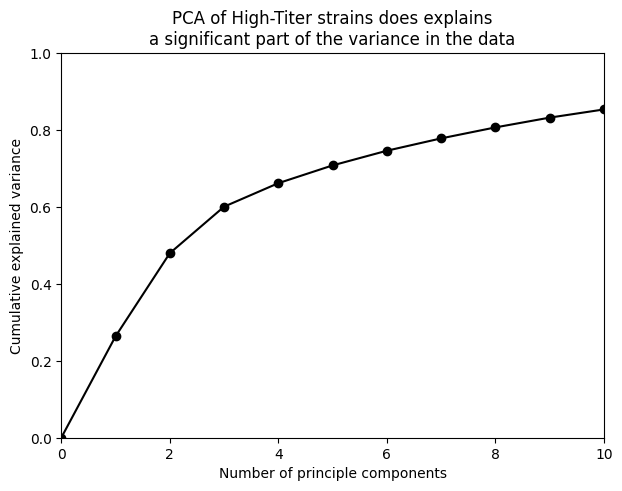

In [62]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')
ax.set_title('PCA of High-Titer strains does explains\na significant part of the variance in the data')
# fig.savefig('./figures/PCA_var_exp.png')

### Do volcano plots on different clusters 

In [63]:
cluster_df = high_dist_df.copy()
cluster_df['cluster'] = fc
cluster_df

Control_c0    Control_c1    Control_c2  \
Control_c0                          0.000000e+00  1.303414e-14  1.267271e-14   
Control_c1                          1.303414e-14  0.000000e+00  1.680147e-14   
Control_c2                          1.267271e-14  1.680147e-14  0.000000e+00   
Control_c3                          1.196868e-14  1.726755e-14  1.653016e-14   
Control_c4                          1.261755e-14  1.683047e-14  1.658273e-14   
Control_c5                          1.314147e-14  1.743383e-14  1.728750e-14   
Control_c6                          1.269447e-14  1.727918e-14  1.744753e-14   
PP_0368_PP_0751_PP_0812_c5          3.718320e+01  3.718320e+01  3.718320e+01   
PP_0368_PP_0812_PP_0815_PP_2136_c5  3.434788e+01  3.434788e+01  3.434788e+01   
PP_0751_PP_0812_PP_0815_c6          7.232459e+01  7.232459e+01  7.232459e+01   
PP_0812_PP_0815_PP_1506_c6          6.325380e+01  6.325380e+01  6.325380e+01   
PP_0368_PP_0813_PP_0814_PP_0815_c6  4.388476e+01  4.388476e+01  4.388476e+01   
PP_0813_PP_0814_PP_0815_c5          3.985280e+01  3.985280e+01  3.985280e+01   
PP_0368_PP_0751_PP_0815_c5          4.008434e+01  4.008434e+01  4.008434e+01   
PP_0812_PP_0813_PP_0815_PP_1506_c6  7.491618e+01  7.491618e+01  7.491618e+01   
PP_0813_PP_0815_c4                  6.174738e+01  6.174738e+01  6.174738e+01   
PP_0437_PP_0815_PP_1317_c4          7.003257e+01  7.003257e+01  7.003257e+01   
PP_0368_PP_0751_PP_0812_PP_0815_c5  3.248409e+01  3.248409e+01  3.248409e+01   
PP_0368_PP_0812_PP_0815_c4          6.752508e+01  6.752508e+01  6.752508e+01   
PP_0814_PP_0815_c4                  6.576132e+01  6.576132e+01  6.576132e+01   
PP_0528_PP_0813_PP_0815_c6          7.620514e+01  7.620514e+01  7.620514e+01   
PP_0812_PP_0813_PP_0815_c4          7.588922e+01  7.588922e+01  7.588922e+01   
PP_0815_PP_1317_PP_1506_c4          7.078692e+01  7.078692e+01  7.078692e+01   
PP_0528_PP_0815_c4                  6.114659e+01  6.114659e+01  6.114659e+01   
PP_0751_PP_0813_PP_0815_c6          5.580134e+01  5.580134e+01  5.580134e+01   
PP_0528_PP_0812_PP_0815_c4          6.987637e+01  6.987637e+01  6.987637e+01   
PP_0751_PP_0815_c4                  5.701313e+01  5.701313e+01  5.701313e+01   
PP_0368_PP_0751_PP_0813_PP_0815_c6  7.030027e+01  7.030027e+01  7.030027e+01   
PP_0815_PP_2136_c5                  3.964994e+01  3.964994e+01  3.964994e+01   
PP_0528_PP_0751_PP_0815_c6          5.389268e+01  5.389268e+01  5.389268e+01   
PP_0815_PP_4189_c4                  7.843317e+01  7.843317e+01  7.843317e+01   
PP_0368_PP_0812_PP_0813_PP_0815_c5  3.443072e+01  3.443072e+01  3.443072e+01   
PP_0368_PP_0751_PP_0814_PP_0815_c6  5.869073e+01  5.869073e+01  5.869073e+01   
PP_0528_PP_0751_PP_0813_PP_0815_c6  7.357331e+01  7.357331e+01  7.357331e+01   
PP_0528_PP_0751_PP_0812_PP_0815_c6  6.806598e+01  6.806598e+01  6.806598e+01   
PP_0368_PP_0815_c4                  6.790460e+01  6.790460e+01  6.790460e+01   
PP_0368_PP_0814_PP_0815_c5          4.388628e+01  4.388628e+01  4.388628e+01   

                                      Control_c3    Control_c4    Control_c5  \
Control_c0                          1.196868e-14  1.261755e-14  1.314147e-14   
Control_c1                          1.726755e-14  1.683047e-14  1.743383e-14   
Control_c2                          1.653016e-14  1.658273e-14  1.728750e-14   
Control_c3                          0.000000e+00  1.590473e-14  1.682520e-14   
Control_c4                          1.590473e-14  0.000000e+00  1.655698e-14   
Control_c5                          1.682520e-14  1.655698e-14  0.000000e+00   
Control_c6                          1.633840e-14  1.683101e-14  1.732410e-14   
PP_0368_PP_0751_PP_0812_c5          3.718320e+01  3.718320e+01  3.718320e+01   
PP_0368_PP_0812_PP_0815_PP_2136_c5  3.434788e+01  3.434788e+01  3.434788e+01   
PP_0751_PP_0812_PP_0815_c6          7.232459e+01  7.232459e+01  7.232459e+01   
PP_0812_PP_0815_PP_1506_c6          6.325380e+01  6.325380e+01  6.325380e+01   
PP_0368_PP_0813_PP_0814_PP_0815_c6  4

In [64]:
clustered_lines = [line[:-3] for line in high_dist_df.columns]
clustered_lines = high_dist_df.columns
clustered_line_dict = dict(zip(clustered_lines, cluster_df.loc[:,'cluster']))
clustered_line_dict

{'Control_c0': 1,
 'Control_c1': 1,
 'Control_c2': 1,
 'Control_c3': 1,
 'Control_c4': 1,
 'Control_c5': 1,
 'Control_c6': 1,
 'PP_0368_PP_0751_PP_0812_c5': 2,
 'PP_0368_PP_0812_PP_0815_PP_2136_c5': 2,
 'PP_0751_PP_0812_PP_0815_c6': 3,
 'PP_0812_PP_0815_PP_1506_c6': 3,
 'PP_0368_PP_0813_PP_0814_PP_0815_c6': 2,
 'PP_0813_PP_0814_PP_0815_c5': 2,
 'PP_0368_PP_0751_PP_0815_c5': 2,
 'PP_0812_PP_0813_PP_0815_PP_1506_c6': 3,
 'PP_0813_PP_0815_c4': 6,
 'PP_0437_PP_0815_PP_1317_c4': 6,
 'PP_0368_PP_0751_PP_0812_PP_0815_c5': 2,
 'PP_0368_PP_0812_PP_0815_c4': 5,
 'PP_0814_PP_0815_c4': 4,
 'PP_0528_PP_0813_PP_0815_c6': 3,
 'PP_0812_PP_0813_PP_0815_c4': 5,
 'PP_0815_PP_1317_PP_1506_c4': 4,
 'PP_0528_PP_0815_c4': 4,
 'PP_0751_PP_0813_PP_0815_c6': 2,
 'PP_0528_PP_0812_PP_0815_c4': 6,
 'PP_0751_PP_0815_c4': 6,
 'PP_0368_PP_0751_PP_0813_PP_0815_c6': 3,
 'PP_0815_PP_2136_c5': 2,
 'PP_0528_PP_0751_PP_0815_c6': 2,
 'PP_0815_PP_4189_c4': 4,
 'PP_0368_PP_0812_PP_0813_PP_0815_c5': 2,
 'PP_0368_PP_0751_PP_081

In [65]:
cluster_df = omics.copy()
cluster_df['line_name'] = [f"{x.split('-')[0]}_c{x[-1]}" for x in cluster_df.index.values]
cluster_df['is_control'] = ['ontrol' in x for x in cluster_df['line_name']]
cluster_df.loc[cluster_df['is_control'], 'line_name'] = cluster_df.loc[
    cluster_df['is_control'], 'line_name'].apply(lambda x: f'Control_c{x[-1]}')
cluster_df['has_cluster'] = cluster_df['line_name'].apply(lambda x: x in clustered_lines)

cluster_df = cluster_df[cluster_df['has_cluster']]

cluster_df['cluster'] = cluster_df['line_name'].apply(lambda x: clustered_line_dict[x])
# cluster_df = cluster_df.drop(['line_name', 'is_control', 'has_cluster'], axis = 1)

cluster_df

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                       
Control-R10_c0         0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0         1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0         1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0         0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0         0.920443  1.294411  1.084229  1.028170  0.825054   
...                         ...       ...       ...       ...       ...   
PP_0815_PP_2136-R2_c5  1.483004  0.455116  0.527055  1.001524  0.579934   
PP_0815_PP_2136-R3_c5  1.423489  0.734009  0.611613  1.107580  0.579620   
PP_0815_PP_4189-R1_c4  1.132156  0.871319  0.060076  0.218182  0.489499   
PP_0815_PP_4189-R2_c4  0.364509  0.068061  0.152403  0.174538  0.428888   
PP_0815_PP_4189-R3_c4  0.832159  0.000000  0.000000  0.000000  0.662569   

                        PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                      ...   
Control-R10_c0         0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0         0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0         1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0         0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0         0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                         ...       ...       ...       ...       ...  ...   
PP_0815_PP_2136-R2_c5  0.954919  0.510812  0.600263  1.116737  1.236248  ...   
PP_0815_PP_2136-R3_c5  0.758004  0.439930  0.498927  0.981812  1.121260  ...   
PP_0815_PP_4189-R1_c4  0.597489  0.745851  0.004630  0.565950  0.790930  ...   
PP_0815_PP_4189-R2_c4  0.645944  0.755148  0.011746  0.417505  0.340372  ...   
PP_0815_PP_4189-R3_c4  1.537548  0.560199  0.000000  0.404285  0.686682  ...   

                        PP_5418  SPy_1046   YNR043W  b4055 JW4015       neo  \
line_name_rep_cycle                                                           
Control-R10_c0         0.000000  1.275427  0.988950      1.075991  1.110129   
Control-R11_c0         0.022315  1.095618  1.066124      1.224033  1.058979   
Control-R12_c0         6.881715  1.179865  1.025106      0.905480  1.131022   
Control-R13_c0         0.021247  0.819190  1.014700      0.904057  0.896219   
Control-R14_c0         0.045492  0.901863  1.047413      0.997991  1.083941   
...                         ...       ...       ...           ...       ...   
PP_0815_PP_2136-R2_c5  1.209638  0.664228  1.206559      1.229014  1.030521   
PP_0815_PP_2136-R3_c5  0.446414  0.579263  1.101211      1.194512  1.081268   
PP_0815_PP_4189-R1_c4  1.464361  0.950505  1.149569      0.602048  0.810483   
PP_0815_PP_4189-R2_c4  3.713202  1.164241  0.599127      1.064763  0.367742   
PP_0815_PP_4189-R3_c4  2.758752  1.471290  0.985913      1.239173  0.649886   

                       isoprenol           line_name  is_control  has_cluster  \
line_name_rep_cycle                                                             
Control-R10_c0          1.024392          Control_c0        True         True   
Control-R11_c0          1.120367          Control_c0        True         True   
Control-R12_c0          1.178920          Control_c0        True         True   
Control-R13_c0          0.720284          Control_c0        True         True   
Control-R14_c0          1.030501          Control_c0        True         True   
...                          ...                 ...         ...          ...   
PP_0815_PP_2136-R2_c5   3.505734  PP_0815_PP_2136_c5       False         True   
PP_0815_PP_2136-R3_c5   3.426804  PP_0815_PP_2136_c5       False         True   
PP_0815_PP_4189-R1_c4   3.461911  PP_0815_PP_4189_c4       False         True   
PP_0815_PP_4189-R2_c4   3.551910  PP_0815_PP_4189_c4       False         True   
PP_0815

In [66]:
cluster_df['cluster'].value_counts()

cluster
1    90
2    33
3    24
6    12
4    12
5     9
Name: count, dtype: int64

In [67]:
np.array([0,1,2,3,4,5,6])+0.1

array([0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1])

In [68]:
violin_palette = dict(zip([1,2,3,4, 5, 6], ['k','r','g','b','y', 'm']))
sns.violinplot(data = cluster_df, y = 'isoprenol',x = 'cluster', hue = 'cluster', cut = 0, palette=violin_palette)


<Axes: xlabel='cluster', ylabel='isoprenol'>

In [69]:
cluster_df.loc[:,'cluster'].value_counts()

cluster
1    90
2    33
3    24
6    12
4    12
5     9
Name: count, dtype: int64

In [70]:
from scipy import stats
rng = np.random.default_rng()

rvs1 = stats.norm.rvs(loc=6, scale=10, size=5000, random_state=rng)
rvs2 = stats.norm.rvs(loc=5, scale=10, size=5000, random_state=rng)
stats.ttest_ind(rvs1, rvs2)[1]


5.547639605384562e-06

In [71]:
#     #Annotate the points with protein names and adjust for label overlap
#     texts=[]
#     labels = [df_log2.iloc[i, 0] for i in range(len(fold_change))]
#     for i, label in enumerate(labels):
#         if fold_change[i] < -2 and p_values[i] > -np.log10(0.01):
#             text = plt.text(fold_change[i], p_values[i], label, fontsize=10) 
#             texts.append(text)
            
#     if texts:
#         adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red', lw=1))

In [72]:
%pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 19.6 MB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [73]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

In [74]:
def volcano_plot(data1,
                 data2,
                 neglog10pval_thresh = 0.001,
                 log2fc_thresh = 3,
                 title_text = None,
                 label_flag = False,
                 select_proteins = None,
                 adj_pvals = True,
                 plot = True,
                 figsize = (10,10)
                ):
    # data1 and data2 are 
    common_columns = list(set(data1.columns).intersection(set(data2.columns)))
    df = pd.DataFrame(columns = ['prot', 'log2fc', 'pval', 'pval_adj', 'neglog10p'], index = common_columns)
    for c in common_columns:
        l2fc = np.log2(np.mean(data2.loc[:, c])/np.mean(data1.loc[:,c]))
        pval = ttest_ind(data1.loc[:,c], data2.loc[:,c])[1]
        # nl10p = -np.log10(
        #     pval            
        # )
        
        df.loc[c,:] = [c, l2fc, pval, np.nan, np.nan]
    
    reject, pvals_corrected, _, _ = multipletests(
                                        df['pval'].values,
                                        alpha=0.05,
                                        method='fdr_bh',
                                        maxiter=1,
                                        is_sorted=False,
                                        returnsorted=False
                                    )
    df.loc[:, 'pval_adj'] = pvals_corrected
    
    if adj_pvals:
        df.loc[:, 'neglog10p'] = -np.log10(df.loc[:, 'pval_adj'].astype(np.float64))
    else:
        df.loc[:, 'neglog10p'] = -np.log10(df.loc[:, 'pval'].astype(np.float64))
        
        
    df.loc[:, 'significant'] = (
        (np.abs(df.loc[:,'log2fc'])>log2fc_thresh) & 
        (df.loc[:,'neglog10p']>neglog10pval_thresh)
    )

    df.loc[:, 'selected'] = False
    if select_proteins is not None:
        df.loc[:, 'selected'] = df['prot'].isin(select_proteins)

    df.loc[:, 'color'] = 'black'
    df.loc[df['significant'],'color'] = 'red'
    df.loc[df['selected'], 'color'] = 'blue'
    
    
    if plot:            
        fig, ax = plt.subplots(figsize = figsize)
        line_params = {'linestyle': '--', 'color': 'k', 'linewidth': 0.5} 
        ax.axvline(np.abs(log2fc_thresh), **line_params)
        ax.axvline(-np.abs(log2fc_thresh), **line_params)
        ax.axhline(np.abs(neglog10pval_thresh), **line_params)
        if title_text:
            ax.set_title(title_text)
        sns.scatterplot(data = df[df['color'] == 'black'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', alpha = 0.1, color = 'k')
        sns.scatterplot(data = df[df['color'] == 'red'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'r')
        sns.scatterplot(data = df[df['color'] == 'blue'], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'b')

        if adj_pvals: 
            ylabel = r'$-log_{10}(Adj. p-val)$'
        else: 
            ylabel = r'$-log_{10}(p-val)$'

        ax.set_xlabel('log2(fold change)')
        ax.set_ylabel(ylabel)
        if label_flag:
            label_idx_sig = (
                (np.abs(df.loc[:,'log2fc'])>log2fc_thresh) & 
                (df.loc[:,'neglog10p']>neglog10pval_thresh)
            )
            label_idx = label_idx_sig | df['selected']
            text_x = df.loc[label_idx, 'log2fc'].values
            text_y = df.loc[label_idx, 'neglog10p'].values
            text_lbl = df.loc[label_idx, 'prot'].values

            text_list = [plt.text(text_x[i], text_y[i], text_lbl[i], fontsize = 10) for i in range(sum(label_idx))]


            adjust_text(text_list, arrowprops=dict(arrowstyle='-', color='red', lw=1)) 
        else:
            select_proteins_label_idx = df['significant']
            sns.scatterplot(data = df[select_proteins_label_idx], x = 'log2fc', y = 'neglog10p', edgecolors = 'k', color = 'b')

            select_proteins_x = df.loc[select_proteins_label_idx, 'log2fc'].values
            select_proteins_y = df.loc[select_proteins_label_idx, 'neglog10p'].values
            select_proteins_lbl = df.loc[select_proteins_label_idx, 'prot'].values
            select_proteins_text_list = [plt.text(select_proteins_x[i], select_proteins_y[i], select_proteins_lbl[i], fontsize = 10) for i in range(sum(select_proteins_label_idx))]
            adjust_text(select_proteins_text_list, arrowprops=dict(arrowstyle='-', color='blue', lw=1))


    return df

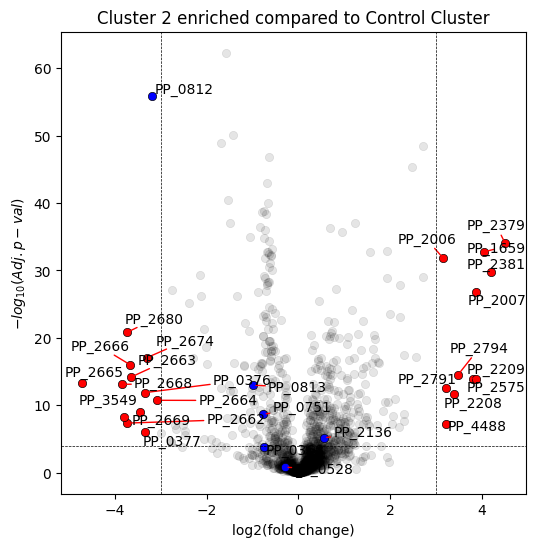

In [75]:
cluster_compare = 2
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_df_adj = volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    adj_pvals = True,
    figsize=(6,6)
)

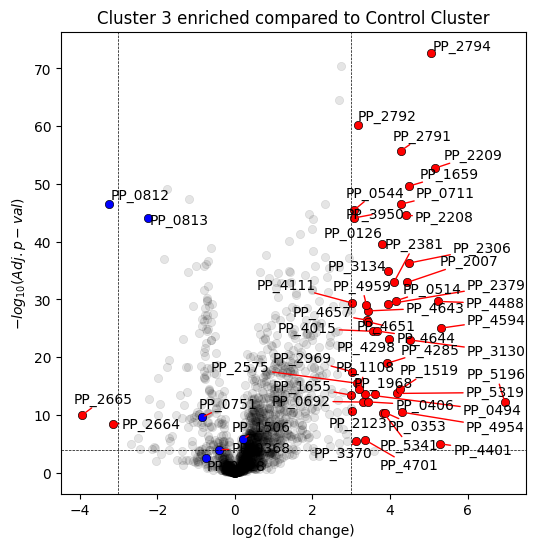

In [76]:
cluster_compare = 3
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_df_adj = volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    adj_pvals = True,
    figsize=(6,6)
)

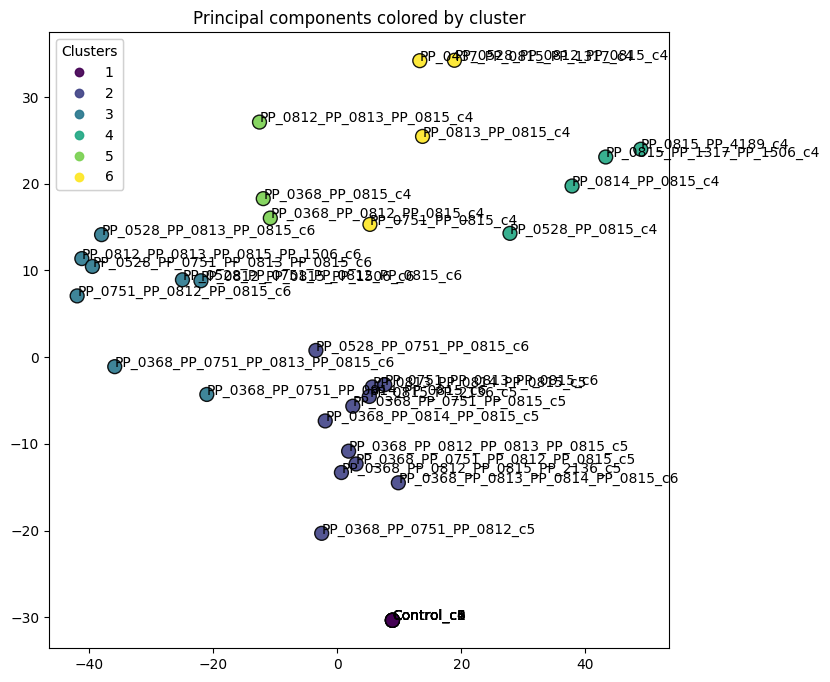

In [77]:
pca = PCA(n_components = 10)
cluster_pca = pca.fit_transform(X_cluster_df.loc[:,protein_measurements])
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
sc = ax.scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
legend1 = ax.legend(*sc.legend_elements(), loc = 'upper left', title = 'Clusters')
ax.add_artist(legend1)
ax.set_title('Principal components colored by cluster')
for i in range(len(cluster_pca)):
    ax.annotate(X_cluster_df.index[i], (cluster_pca[i,0],cluster_pca[i,1]))

In [78]:
cluster_compare = 2
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    figsize=(6,6)
)

prot    log2fc      pval  pval_adj  neglog10p  significant  \
PP_2087  PP_2087  0.617055       0.0       0.0  10.898035        False   
PP_1235  PP_1235  0.795465       0.0       0.0   7.763458        False   
PP_2387  PP_2387 -0.427206  0.091962  0.134349   0.871765        False   
PP_0787  PP_0787 -0.089585  0.535143  0.612603   0.212821        False   
PP_1014  PP_1014  1.020167       0.0       0.0   9.900988        False   
...          ...       ...       ...       ...        ...          ...   
PP_1056  PP_1056  0.050788  0.634499  0.701918   0.153714        False   
PP_5145  PP_5145  0.450472       0.0       0.0    10.1812        False   
PP_4474  PP_4474  0.015361  0.514214  0.592354   0.227419        False   
PP_0003  PP_0003  0.282267  0.003178  0.006487   2.187976        False   
PP_4719  PP_4719 -0.406829  0.240075  0.310963   0.507291        False   

         selected  color  
PP_2087     False  black  
PP_1235     False  black  
PP_2387     False  black  
PP_0787     False  black  
PP_1014     False  black  
...           ...    ...  
PP_1056     False  black  
PP_5145     False  black  
PP_4474     False  black  
PP_0003     False  black  
PP_4719     False  black  

[1645 rows x 8 columns]

In [79]:
cluster_compare = 4
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    figsize=(6,6)
)

prot    log2fc      pval  pval_adj  neglog10p  significant  \
PP_2087  PP_2087  0.416529  0.000719  0.001395   2.855514        False   
PP_1235  PP_1235  0.104321  0.574664  0.622332   0.205978        False   
PP_2387  PP_2387 -0.777767  0.090222  0.117231   0.930956        False   
PP_0787  PP_0787 -1.884449  0.000001  0.000003   5.472169        False   
PP_1014  PP_1014  0.764336  0.000004   0.00001   4.981641        False   
...          ...       ...       ...       ...        ...          ...   
PP_1056  PP_1056  0.206173  0.232047  0.276947   0.557603        False   
PP_5145  PP_5145  0.435945  0.000015  0.000038   4.420073        False   
PP_4474  PP_4474 -0.239709       0.0       0.0   6.905717        False   
PP_0003  PP_0003 -2.483797       0.0       0.0  13.842863        False   
PP_4719  PP_4719 -1.523634  0.051975  0.070954   1.149024        False   

         selected  color  
PP_2087     False  black  
PP_1235     False  black  
PP_2387     False  black  
PP_0787     False  black  
PP_1014     False  black  
...           ...    ...  
PP_1056     False  black  
PP_5145     False  black  
PP_4474     False  black  
PP_0003     False  black  
PP_4719     False  black  

[1645 rows x 8 columns]

prot    log2fc      pval  pval_adj neglog10p  significant  \
PP_2087  PP_2087 -0.200526  0.170191  0.223256  0.651196        False   
PP_1235  PP_1235 -0.691144  0.013652  0.023492   1.62908        False   
PP_2387  PP_2387 -0.350562  0.483156  0.553476  0.256901        False   
PP_0787  PP_0787 -1.794865  0.000014  0.000045  4.342788        False   
PP_1014  PP_1014 -0.255831  0.300285  0.364284   0.43856        False   
...          ...       ...       ...       ...       ...          ...   
PP_1056  PP_1056  0.155385   0.36533  0.434539  0.361971        False   
PP_5145  PP_5145 -0.014527  0.851977  0.876979  0.057011        False   
PP_4474  PP_4474 -0.255069       0.0  0.000001  6.047638        False   
PP_0003  PP_0003 -2.766064       0.0       0.0  7.584315         True   
PP_4719  PP_4719 -1.116805  0.024611  0.039498  1.403424        False   

         selected  color  
PP_2087     False  black  
PP_1235     False  black  
PP_2387     False  black  
PP_0787     False  black  
PP_1014     False  black  
...           ...    ...  
PP_1056     False  black  
PP_5145     False  black  
PP_4474     False  black  
PP_0003     False    red  
PP_4719     False  black  

[1645 rows x 8 columns]

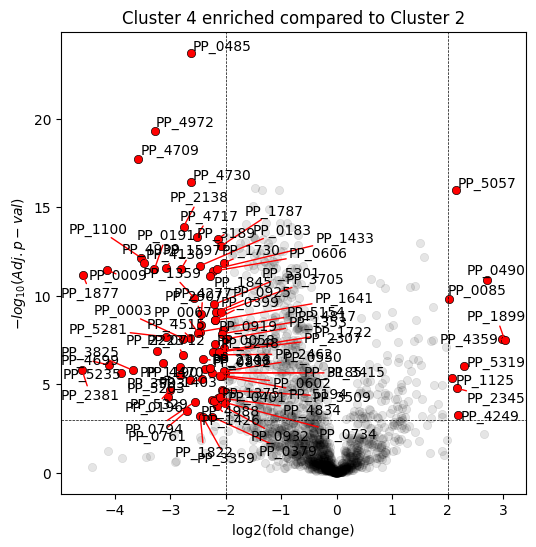

In [80]:
cluster_compare = 4
cluster_baseline = 2
title_text = f'Cluster {cluster_compare} enriched compared to Cluster {cluster_baseline}'

volcano_plot(
    cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=2,
    neglog10pval_thresh=-np.log10(0.001),
    label_flag = True,
    title_text=title_text,
    figsize = (6,6),
)

In [81]:
cluster_A = 4
cluster_B = 1
title_text = f'Cluster {cluster_A} enriched compared to Control Cluster'

volcano_plot(
    cluster_df.loc[cluster_df['cluster'] == cluster_A, protein_measurements],
    cluster_df.loc[cluster_df['cluster'] == cluster_B, protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text
)

prot    log2fc      pval  pval_adj  neglog10p  significant  \
PP_2087  PP_2087 -0.416529  0.000719  0.001395   2.855514        False   
PP_1235  PP_1235 -0.104321  0.574664  0.622332   0.205978        False   
PP_2387  PP_2387  0.777767  0.090222  0.117231   0.930956        False   
PP_0787  PP_0787  1.884449  0.000001  0.000003   5.472169        False   
PP_1014  PP_1014 -0.764336  0.000004   0.00001   4.981641        False   
...          ...       ...       ...       ...        ...          ...   
PP_1056  PP_1056 -0.206173  0.232047  0.276947   0.557603        False   
PP_5145  PP_5145 -0.435945  0.000015  0.000038   4.420073        False   
PP_4474  PP_4474  0.239709       0.0       0.0   6.905717        False   
PP_0003  PP_0003  2.483797       0.0       0.0  13.842863        False   
PP_4719  PP_4719  1.523634  0.051975  0.070954   1.149024        False   

         selected  color  
PP_2087     False  black  
PP_1235     False  black  
PP_2387     False  black  
PP_0787     False  black  
PP_1014     False  black  
...           ...    ...  
PP_1056     False  black  
PP_5145     False  black  
PP_4474     False  black  
PP_0003     False  black  
PP_4719     False  black  

[1645 rows x 8 columns]

In [82]:
cluster_high = 3
high_from_cluster = cluster_df.loc[cluster_df['cluster'] == cluster_high, 'isoprenol'].sort_values(ascending = False).head(1).index.values[0]
high_from_cluster_linename = f'{high_from_cluster.split("-")[0]}_c{high_from_cluster[-1]}'
high_from_cluster_linename

title_text = f'Cluster {cluster_high} max strain: {high_from_cluster_linename} enriched compared to Control'

volcano_plot(
    data2 = cluster_df.loc[cluster_df['line_name'] == high_from_cluster_linename, protein_measurements],
    data1 = cluster_df.loc[cluster_df['is_control'], protein_measurements],
    log2fc_thresh=3,
    neglog10pval_thresh=-np.log10(0.0001),
    label_flag = True,
    title_text=title_text
)

# cluster_df

prot    log2fc      pval  pval_adj neglog10p  significant  \
PP_2087  PP_2087  0.527227  0.016016  0.041231  1.384775        False   
PP_1235  PP_1235  1.272117  0.000003  0.000018  4.747782        False   
PP_2387  PP_2387 -0.229271  0.751853  0.830841  0.080482        False   
PP_0787  PP_0787  1.285915  0.000004  0.000024  4.614337        False   
PP_1014  PP_1014   1.72105       0.0       0.0   7.59087        False   
...          ...       ...       ...       ...       ...          ...   
PP_1056  PP_1056 -0.025113  0.940253  0.960097  0.017685        False   
PP_5145  PP_5145  0.430168  0.020129  0.049793  1.302834        False   
PP_4474  PP_4474 -0.154115  0.042433  0.093193  1.030617        False   
PP_0003  PP_0003  0.189347  0.422177  0.560971   0.25106        False   
PP_4719  PP_4719  0.323814  0.705863  0.794761  0.099764        False   

         selected  color  
PP_2087     False  black  
PP_1235     False  black  
PP_2387     False  black  
PP_0787     False  black  
PP_1014     False  black  
...           ...    ...  
PP_1056     False  black  
PP_5145     False  black  
PP_4474     False  black  
PP_0003     False  black  
PP_4719     False  black  

[1645 rows x 8 columns]

### Visualize PCs 1, 2, and 3:
We can see that PC3 basically just separates the 3rd (green cluster)

In [83]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (5,10))
ax[0].scatter(cluster_pca[:,0], cluster_pca[:,1], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
ax[0].set_title('Principal components colored by cluster')
ax[0].set_ylabel('PC2')
ax[1].scatter(cluster_pca[:,0], cluster_pca[:,2], c = X_cluster_df['cluster'], s = 100, alpha = 0.9, edgecolors='k')
ax[1].set_ylabel('PC3')
ax[1].set_xlabel('PC1')

Text(0.5, 0, 'PC1')

### Plot explained variance:
3 PCs explain about 70% of the variance in the proteomics data among the highest titer strains.

Text(0, 0.5, 'Cumulative explained variance')

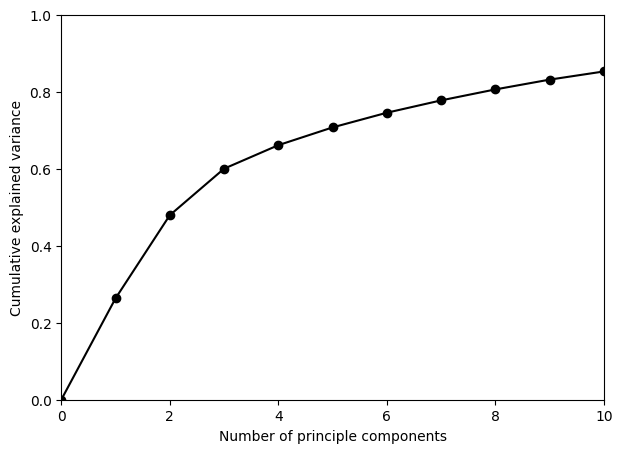

In [84]:
fig, ax = plt.subplots(figsize = (7,5))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
ax.plot(np.arange(0, pca.n_components+1), np.concatenate((np.array([0]), cumulative_variance)), c = 'k', marker = 'o')
ax.set_ylim([0,1])
ax.set_xlim([0, 10])
ax.set_xlabel('Number of principle components')
ax.set_ylabel('Cumulative explained variance')

In [85]:
pca.components_.shape

(10, 1645)

### Plot loadings of first and second principal components

Each principle component has a 'loading' for each protein. That allows us to approximate the proteomics for a given strain as:

$[proteomics measurement] = [PC1 score] * [PC1 loading] + [PC2 score] * [PC2 loading] + ... + [PC_N score] * [PC_N loading]$

So, by looking at the loadings of each principle component, we can can figure out what proteins are most important. For instance, going from the control points to cluster 3 means moving primarily along the PC1 axis. So, if we look at the highest loadings of PC1, we'd expect these to increase from the control to cluster 3. 

In [86]:
cluster_pca_loading_df = pd.DataFrame(data = pca.components_, columns=protein_measurements, index=[f'pc_{i}' for i in range(1, 1+pca.n_components_)])
cluster_pca_loading_df.loc['pc_1',:].sort_values(ascending = False).head(5)

PP_5302    0.047968
PP_0258    0.044924
PP_1899    0.042478
PP_1002    0.040076
PP_1893    0.039554
Name: pc_1, dtype: float64

In [87]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,5))
for i, a in enumerate(ax):
    sns.histplot(data = cluster_pca_loading_df.iloc[i,:], ax = a)
    
fig.tight_layout()

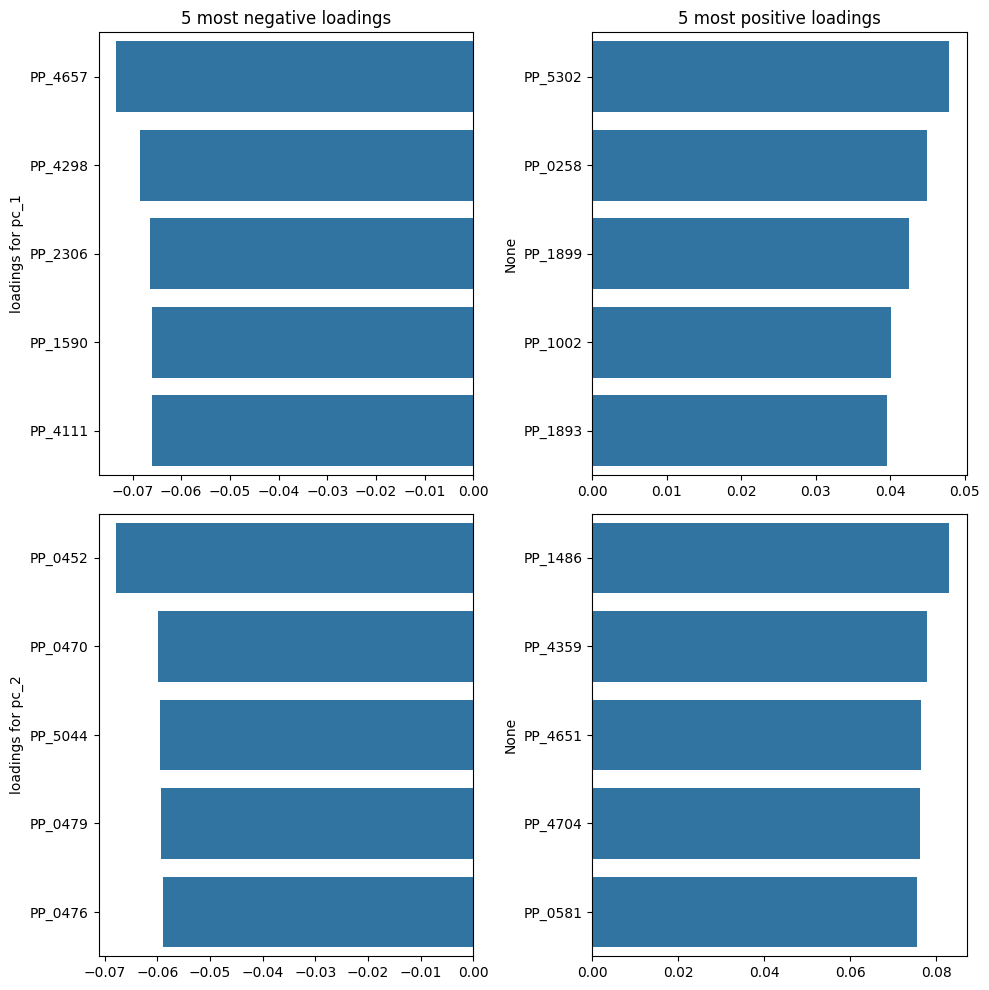

In [88]:
n_to_plot = 5
fig, ax = plt.subplots(2,2, figsize = (10,10))
for i, pc in enumerate(['pc_1', 'pc_2']):#, 'pc_3']):
    sorted_pc = cluster_pca_loading_df.loc[pc,:].sort_values()
    # sns.barplot(data = sorted_pc[:10], x = sorted_pc.values[:10], y = sorted_pc.index[:10],   ax = ax[i,0])
    sns.barplot( x = sorted_pc.values[:n_to_plot], y = sorted_pc.index[:n_to_plot],   ax = ax[i,0])
    # sns.barplot( x = sorted_pc.values[-n_to_plot::-1], y = sorted_pc.index[-n_to_plot::-1],   ax = ax[i,1])
    sns.barplot( x = sorted_pc.values[-1:-n_to_plot-1:-1], y = sorted_pc.index[-1:-n_to_plot-1:-1],   ax = ax[i,1])

    ax[i,0].set_ylabel(f'loadings for {pc}')
    
ax[0,0].set_title(f'{n_to_plot} most negative loadings')
ax[0,1].set_title(f'{n_to_plot} most positive loadings')
fig.tight_layout()

## Differential expression analysis: 

from here: https://www.nature.com/articles/s41467-024-47899-w 


~~~
We took DEA tools from those implementations in Bioconductor v3.1572 and those we collected from published literature. From Bioconductor (Bioconductor—BiocViews: https://www.bioconductor.org/packages/release/BiocViews.html#___DifferentialExpression), we used DEA tools designed specifically for proteomics data. We chose them by popularity, given their download numbers (their ranks are shown in brackets; smaller means more popular). Our list includes:
- DEP (272)73, R packages
- DEqMS (452)34, - *
- plgem (769)74 - good w/ spectral counts
- proDA (480)75. - R package
- limma (15)76
- edgeR (25)77 - good w/ spectral counts
- ANOVA20 
- t-test21
- beta_binomial78 - good w/ spectral counts
- MSstats79, *
- SAM21, and 
- ROTS6 

are collected from literature7,44 or related websites. Each DEA tool has a preferred expression matrix type: edgeR, plgem, and beta_binomial are good with spectral counts; while other tools are either agnostic or work well directly with protein intensities. Some other DEA tools are more demanding: MSstats and DEqMS require additional information beyond protein intensities, whereas MSstats require feature-
level data79, and DEqMS needs peptide or spectral counts34. More descriptions of the normalization, imputation, and DEA methods are presented in Supplementary Note 2.
~~~




## Chris's differential expression approach


In [89]:
cluster_compare = 4
cluster_baseline = 1
crispri_targets_in_cluster_compare = ct_df.loc[ct_df['cluster'] == cluster_compare, 'target'].unique()
title_text = f'Cluster {cluster_compare} enriched compared to Control Cluster'

volcano_df_adj = volcano_plot(
    data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
    data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
    log2fc_thresh=2,
    neglog10pval_thresh=-np.log10(0.001),
    label_flag = True,
    title_text=title_text,
    select_proteins=crispri_targets_in_cluster_compare,
    adj_pvals = True,
    figsize=(6,6)
)

Need to iterate through clusters twice - first time to get all of the differentially expressed proteins, then a second time to calculate the log2FC for each protein b/w cluster and control.

In [90]:
dfs = []

# Get the significant 
for cluster in [2, 3, 4, 5, 6]:
    volcano_df = volcano_plot(
        data1 = cluster_df.loc[cluster_df['cluster'] == 1, protein_measurements],
        data2 = cluster_df.loc[cluster_df['cluster'] == cluster, protein_measurements],
        log2fc_thresh=4,
        neglog10pval_thresh=-np.log10(0.00001),
        label_flag = True,
        title_text=title_text,
        select_proteins=crispri_targets_in_cluster_compare,
        adj_pvals = True,
        plot = False,
        figsize=(6,6)
    )
    
    sig_df = volcano_df[volcano_df['significant']].copy(deep = True)
    sig_df.loc[:, 'cluster'] = cluster
    
    dfs.append(sig_df[['prot', 'cluster']])
    
sig_df = pd.concat(dfs)


    
    

In [91]:
index_to_add = np.array('cluster').astype('object')
prot_idx = sig_df['prot'].unique()
new_index = np.concatenate((prot_idx, np.expand_dims(index_to_add, 0)))
sig_fc_df = pd.DataFrame(index = new_index)
for cluster in [2, 3, 4, 5, 6]:
    lines_in_cluster = list(
        set(
            [line[:-6] + line[-3:] for line in cluster_df.loc[cluster_df['cluster'] == cluster].index]
        )
    )
    print(lines_in_cluster)
    print(len(lines_in_cluster))
    for line in lines_in_cluster:
        cycle = line[-1]
        line_name = line[:-3]
        all_lines = [f'{line_name}-R{i}_c{cycle}' for i in [1, 2, 3]]
        line_prot = cluster_df.loc[all_lines, sig_df['prot'].unique()]
        ctrl_prot = cluster_df.loc[cluster_df['is_control'], sig_df['prot'].unique()]
        sig_fc_df.loc[:, line] = np.nan
        sig_fc_df.loc[prot_idx, line] = np.log2(line_prot.mean()/ctrl_prot.mean())
        # sig_fc_df.loc[:, line_name] = line_pr
        sig_fc_df.loc['cluster', line] = cluster




['PP_0368_PP_0751_PP_0812_PP_0815_c5', 'PP_0813_PP_0814_PP_0815_c5', 'PP_0528_PP_0751_PP_0815_c6', 'PP_0368_PP_0812_PP_0815_PP_2136_c5', 'PP_0368_PP_0813_PP_0814_PP_0815_c6', 'PP_0368_PP_0812_PP_0813_PP_0815_c5', 'PP_0368_PP_0751_PP_0815_c5', 'PP_0368_PP_0751_PP_0812_c5', 'PP_0751_PP_0813_PP_0815_c6', 'PP_0368_PP_0814_PP_0815_c5', 'PP_0815_PP_2136_c5']
11
['PP_0528_PP_0813_PP_0815_c6', 'PP_0812_PP_0813_PP_0815_PP_1506_c6', 'PP_0368_PP_0751_PP_0814_PP_0815_c6', 'PP_0528_PP_0751_PP_0813_PP_0815_c6', 'PP_0528_PP_0751_PP_0812_PP_0815_c6', 'PP_0368_PP_0751_PP_0813_PP_0815_c6', 'PP_0812_PP_0815_PP_1506_c6', 'PP_0751_PP_0812_PP_0815_c6']
8
['PP_0528_PP_0815_c4', 'PP_0815_PP_4189_c4', 'PP_0814_PP_0815_c4', 'PP_0815_PP_1317_PP_1506_c4']
4
['PP_0368_PP_0812_PP_0815_c4', 'PP_0368_PP_0815_c4', 'PP_0812_PP_0813_PP_0815_c4']
3
['PP_0751_PP_0815_c4', 'PP_0813_PP_0815_c4', 'PP_0528_PP_0812_PP_0815_c4', 'PP_0437_PP_0815_PP_1317_c4']
4


In [92]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(data = sig_fc_df.T, cmap = 'vlag')

<Axes: >

## Compare with Chris' clustering approach
Chris suggested I:
1) Take the top N strains
2) For each strain, identify DEGs given some threshold
3) Use only those genes to cluster


In [93]:
X_mean_norm[plot_idx,:]

array([[-0.17911913,  0.07363152,  0.46772907, ..., -0.1755225 ,
        -0.07156169,  0.15256523],
       [-0.17911913,  0.07363152,  0.46772907, ..., -0.1755225 ,
        -0.07156169,  0.15256523],
       [-0.17911913,  0.07363152,  0.46772907, ..., -0.1755225 ,
        -0.07156169,  0.15256523],
       ...,
       [ 1.02055218, -0.80816187, -1.08809771, ...,  0.85678862,
        -0.07759199, -0.03375271],
       [ 2.01589816,  1.89626105,  1.34809033, ..., -0.26863929,
        -0.25839919, -0.54443577],
       [ 0.97457636, -0.36718231,  0.06694933, ...,  0.63925445,
         0.05980319, -0.19928319]])

In [ ]:
# volcano_df_adj = volcano_plot(
#     data1 = cluster_df.loc[cluster_df['cluster'] == cluster_baseline, protein_measurements],
#     data2 = cluster_df.loc[cluster_df['cluster'] == cluster_compare, protein_measurements],
#     log2fc_thresh=3,
#     neglog10pval_thresh=-np.log10(0.0001),
#     label_flag = True,
#     title_text=title_text,
#     select_proteins=crispri_targets_in_cluster_compare,
#     adj_pvals = True,
#     figsize=(6,6)
# )

In [116]:
all_sig_proteins = []
for idx, ln in enumerate(cluster_df['line_name'].unique()):
    print(f'{idx}\t{ln}')
    if 'ontrol' not in ln:
        assert sum(cluster_df['line_name']==ln) == 3

        volcano_df_adj = volcano_plot(
            data1 = cluster_df.loc[cluster_df['is_control'], protein_measurements],
            data2 = cluster_df.loc[cluster_df['line_name'] == ln, protein_measurements],
            log2fc_thresh=3,
            neglog10pval_thresh=-np.log10(0.0001),
            plot = False,
            label_flag = True,
            title_text=title_text,
            select_proteins=crispri_targets_in_cluster_compare,
            adj_pvals = True,
            figsize=(6,6)
        )
        all_sig_proteins.extend(volcano_df_adj.loc[volcano_df_adj['significant'], 'prot'])
        


0	Control_c0
1	Control_c1
2	Control_c2
3	Control_c3
4	Control_c4
5	Control_c5
6	Control_c6
7	PP_0368_PP_0751_PP_0812_c5
8	PP_0368_PP_0751_PP_0812_PP_0815_c5
9	PP_0368_PP_0751_PP_0813_PP_0815_c6
10	PP_0368_PP_0751_PP_0814_PP_0815_c6
11	PP_0368_PP_0751_PP_0815_c5
12	PP_0368_PP_0812_PP_0813_PP_0815_c5
13	PP_0368_PP_0812_PP_0815_c4
14	PP_0368_PP_0812_PP_0815_PP_2136_c5
15	PP_0368_PP_0813_PP_0814_PP_0815_c6
16	PP_0368_PP_0814_PP_0815_c5
17	PP_0368_PP_0815_c4
18	PP_0437_PP_0815_PP_1317_c4
19	PP_0528_PP_0751_PP_0812_PP_0815_c6
20	PP_0528_PP_0751_PP_0813_PP_0815_c6
21	PP_0528_PP_0751_PP_0815_c6
22	PP_0528_PP_0812_PP_0815_c4
23	PP_0528_PP_0813_PP_0815_c6
24	PP_0528_PP_0815_c4
25	PP_0751_PP_0812_PP_0815_c6
26	PP_0751_PP_0813_PP_0815_c6
27	PP_0751_PP_0815_c4
28	PP_0812_PP_0813_PP_0815_c4
29	PP_0812_PP_0813_PP_0815_PP_1506_c6
30	PP_0812_PP_0815_PP_1506_c6
31	PP_0813_PP_0814_PP_0815_c5
32	PP_0813_PP_0815_c4
33	PP_0814_PP_0815_c4
34	PP_0815_PP_1317_PP_1506_c4
35	PP_0815_PP_2136_c5
36	PP_0815_PP_4189

In [144]:
high_dmat_squareform.shape

(472, 472)

In [154]:
X_mean_sig.shape

(472, 212)

In [153]:
plot_idx

array([  0,   1,   2,   3,   4,   5,   6,  31,  46, 167, 237,  57, 252,
        39, 227, 263,  93,  30,  47, 288, 119, 228, 305, 138, 173, 113,
       207,  32, 327, 109, 329,  42,  34, 103, 102,  73,  65])

In [179]:
all_sig_proteins = list(set(all_sig_proteins))
all_sig_proteins.sort()
sig_protein_idx = [protein_measurements.get_loc(prot) for prot in all_sig_proteins]
X_mean_sig = X_mean_norm[plot_idx, np.array(sig_protein_idx)[..., np.newaxis]].transpose()


/tmp/ipykernel_19767/154710348.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  high_values_mean = y_mean[high_idx_mean]
/tmp/ipykernel_19767/154710348.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  titer_category_df = pd.DataFrame(y_mean[plot_idx])
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/art/.venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non

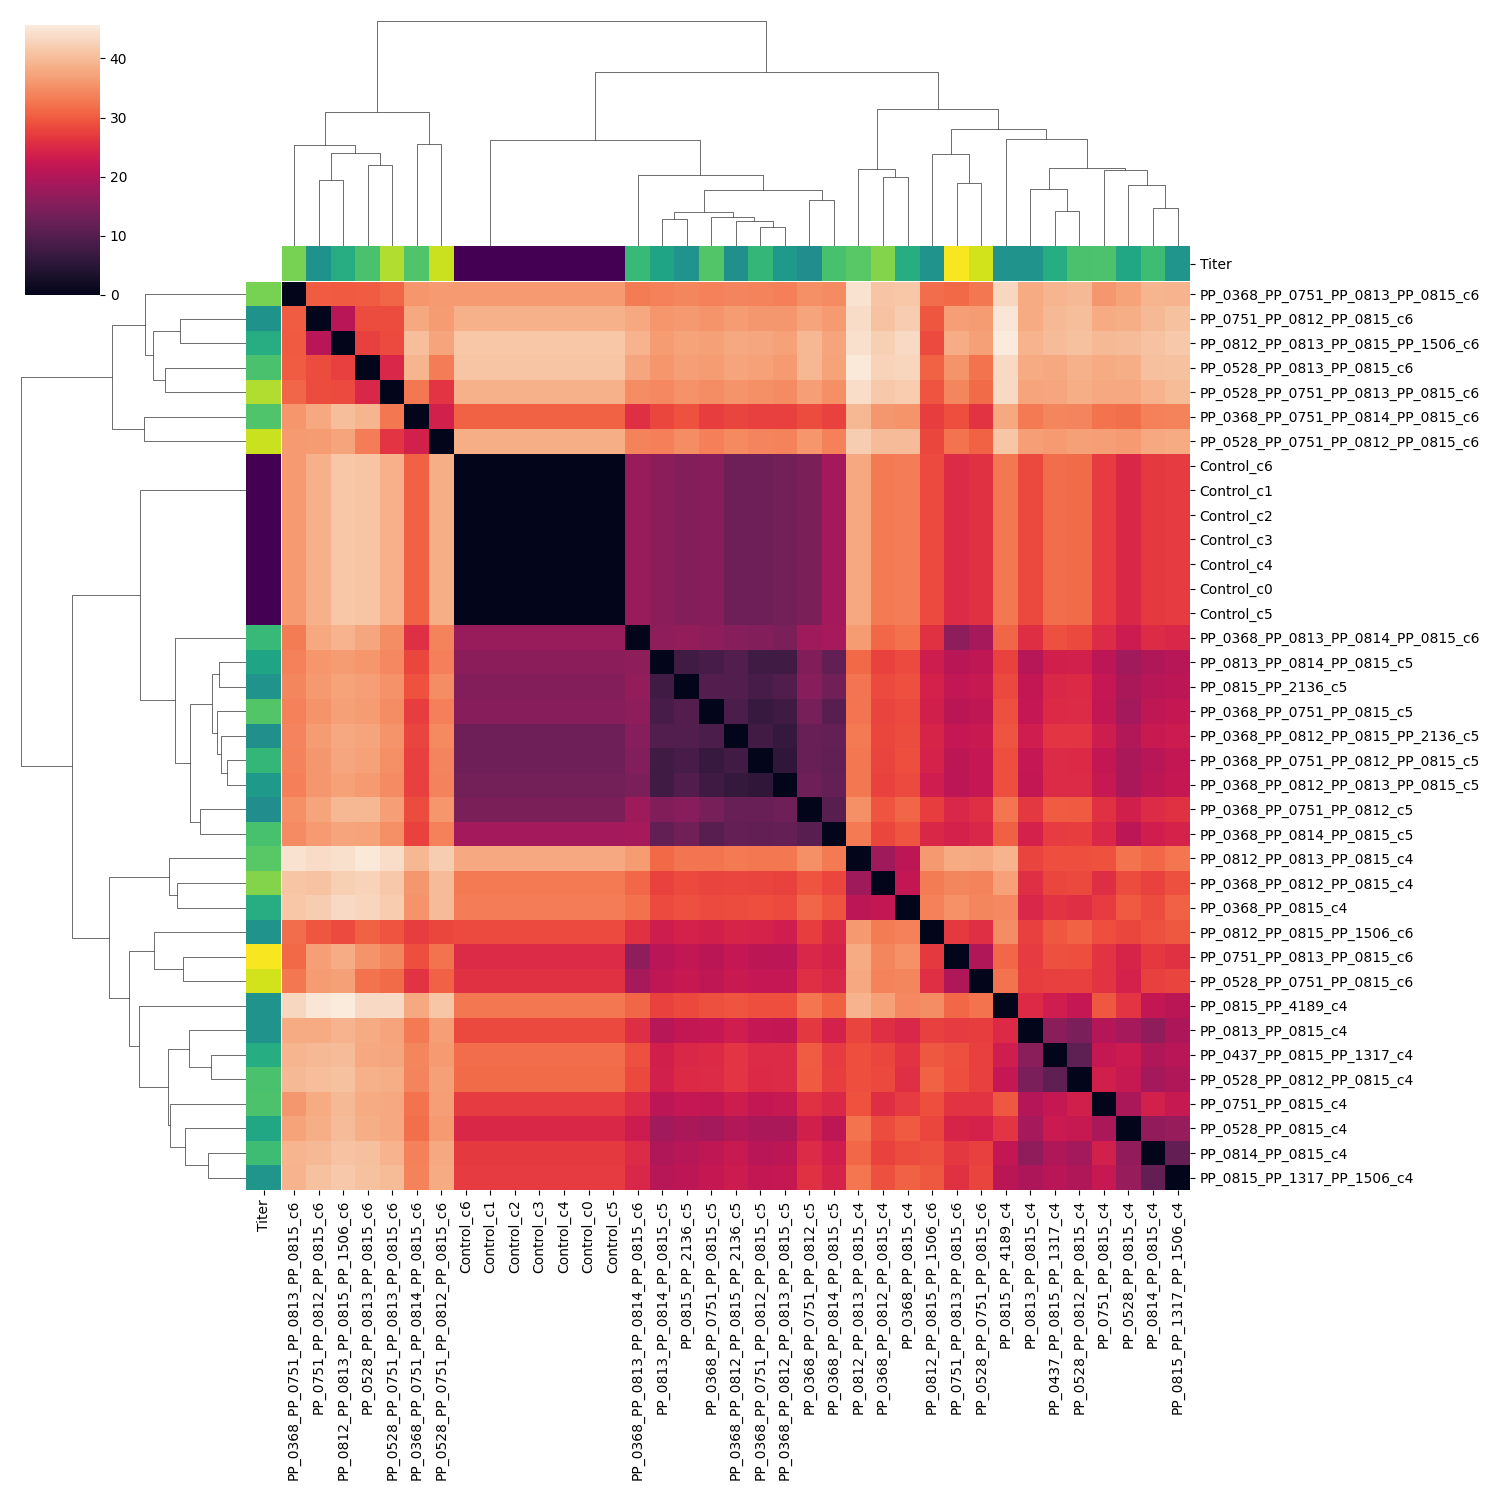

In [180]:
high_idx_mean = np.argpartition(y_mean, -n_high)[-n_high:]
high_values_mean = y_mean[high_idx_mean]

control_idx_mean = np.where(
    np.array(
        ['ontrol' in x for x in X_mean_norm_df.index.values]
    )
)[0]

plot_idx = np.hstack([control_idx_mean, high_idx_mean])
high_dmat_compressed = pdist(X_mean_sig)
high_dmat = squareform(high_dmat_compressed)

titer_category_df = pd.DataFrame(y_mean[plot_idx])

scalar_map = cm.ScalarMappable(
    norm = mpl.colors.Normalize(vmin =2, vmax = 5),
    cmap = plt.get_cmap('viridis'),
)

titer_category_df.loc[:,'c_cont'] = titer_category_df['isoprenol'].apply(lambda x: scalar_map.to_rgba(x))
titer_colors = pd.Series(titer_category_df.loc[:,'c_cont'])
titer_colors.name = 'Titer'

high_dist_df = pd.DataFrame(data = high_dmat, columns = X_mean.index.values[plot_idx], index = X_mean.index.values[plot_idx])
c = sns.clustermap(
    data = high_dist_df,
    row_colors = titer_colors, 
    col_colors=titer_colors,
    figsize=(15,15)
)

In [181]:
dist_linkage = hierarchy.linkage(
    distance.pdist(high_dist_df), method='average')

sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=titer_colors,
               method="average",
               col_colors=titer_colors,
               figsize=(13, 13)
              )

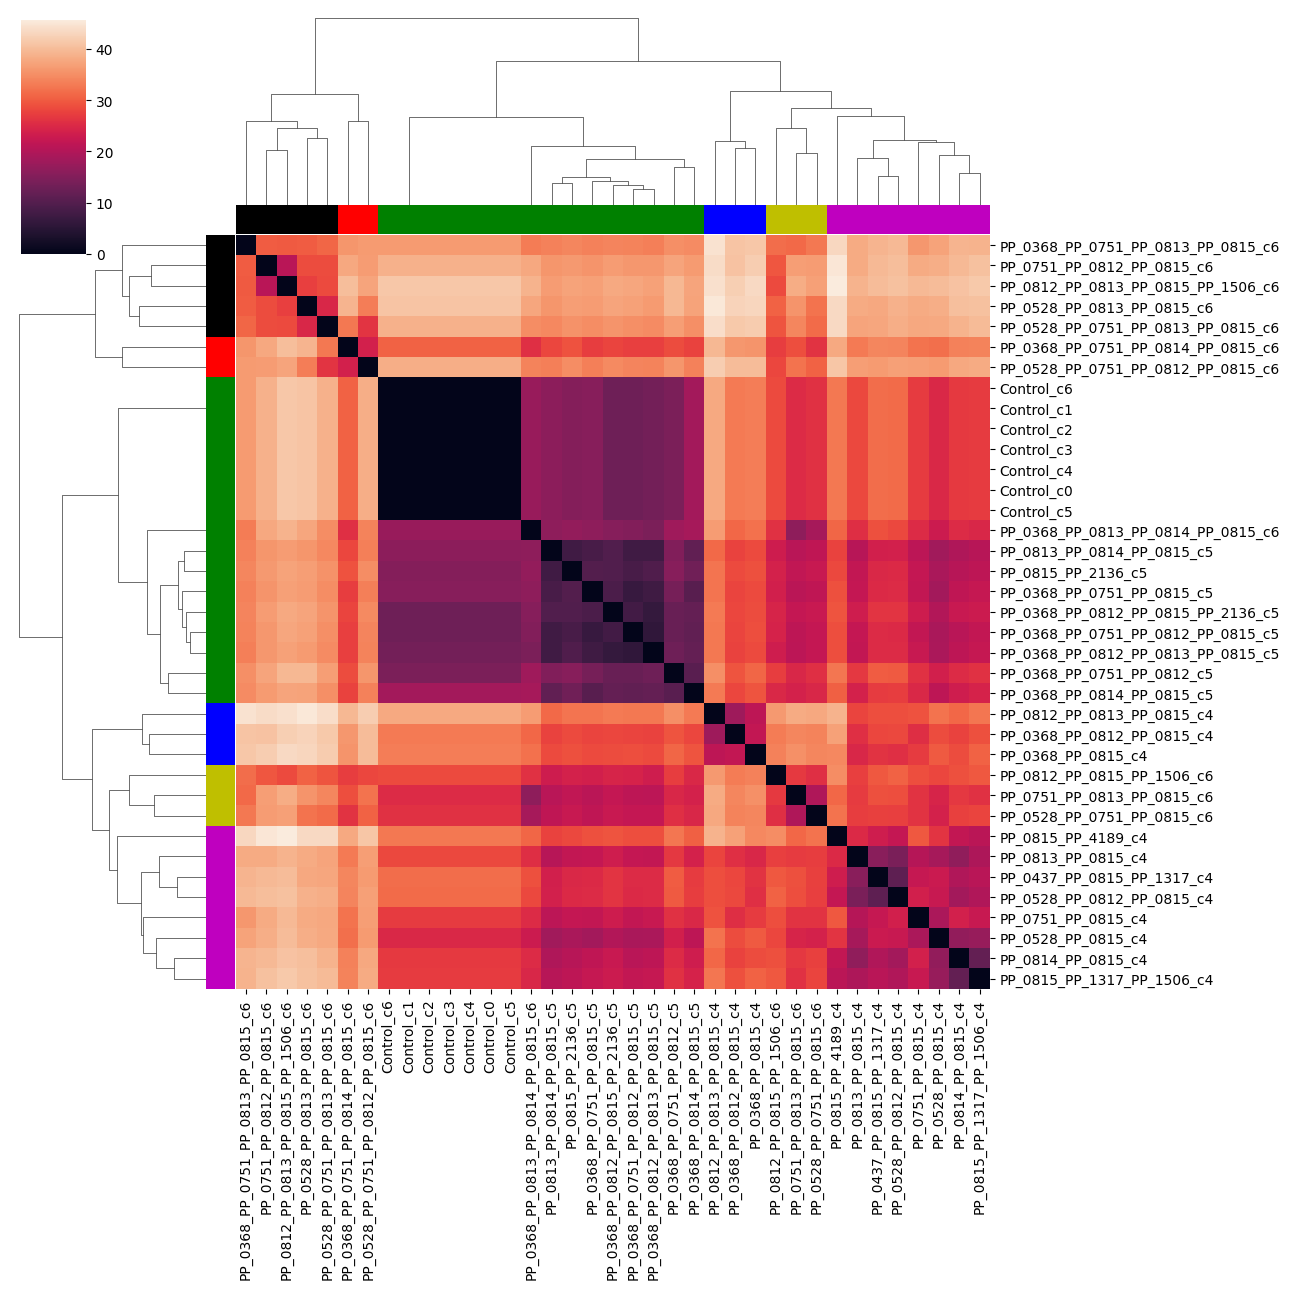

In [184]:
fc = hierarchy.fcluster(dist_linkage, t = 6, criterion='maxclust')
fc
c_all = 'krgbym'
fc_color = [c_all[int(x-1)] for x in fc]
sns.clustermap(high_dist_df, 
               row_linkage=dist_linkage,
               col_linkage=dist_linkage,
               row_colors=fc_color,
               method="average",
               col_colors=fc_color,
               figsize=(13, 13)
              )

In [187]:
cluster_df

MM_1762   PP_0001   PP_0002   PP_0003   PP_0004  \
line_name_rep_cycle                                                       
Control-R10_c0         0.951793  1.094915  0.970530  1.133319  0.957359   
Control-R11_c0         1.047312  0.771961  0.854275  1.007493  0.911182   
Control-R12_c0         1.054954  1.242484  0.500928  1.154855  0.969491   
Control-R13_c0         0.933705  1.051552  1.586093  0.932927  0.992892   
Control-R14_c0         0.920443  1.294411  1.084229  1.028170  0.825054   
...                         ...       ...       ...       ...       ...   
PP_0815_PP_2136-R2_c5  1.483004  0.455116  0.527055  1.001524  0.579934   
PP_0815_PP_2136-R3_c5  1.423489  0.734009  0.611613  1.107580  0.579620   
PP_0815_PP_4189-R1_c4  1.132156  0.871319  0.060076  0.218182  0.489499   
PP_0815_PP_4189-R2_c4  0.364509  0.068061  0.152403  0.174538  0.428888   
PP_0815_PP_4189-R3_c4  0.832159  0.000000  0.000000  0.000000  0.662569   

                        PP_0005   PP_0006   PP_0009   PP_0010   PP_0011  ...  \
line_name_rep_cycle                                                      ...   
Control-R10_c0         0.787047  0.934429  1.095724  1.152434  0.898198  ...   
Control-R11_c0         0.794843  1.079606  1.054531  1.054544  1.061720  ...   
Control-R12_c0         1.662368  0.994657  0.958415  0.958498  1.031600  ...   
Control-R13_c0         0.994851  1.013185  1.252256  1.137690  1.056214  ...   
Control-R14_c0         0.875014  1.036462  1.172617  0.838294  1.033187  ...   
...                         ...       ...       ...       ...       ...  ...   
PP_0815_PP_2136-R2_c5  0.954919  0.510812  0.600263  1.116737  1.236248  ...   
PP_0815_PP_2136-R3_c5  0.758004  0.439930  0.498927  0.981812  1.121260  ...   
PP_0815_PP_4189-R1_c4  0.597489  0.745851  0.004630  0.565950  0.790930  ...   
PP_0815_PP_4189-R2_c4  0.645944  0.755148  0.011746  0.417505  0.340372  ...   
PP_0815_PP_4189-R3_c4  1.537548  0.560199  0.000000  0.404285  0.686682  ...   

                        PP_5418  SPy_1046   YNR043W  b4055 JW4015       neo  \
line_name_rep_cycle                                                           
Control-R10_c0         0.000000  1.275427  0.988950      1.075991  1.110129   
Control-R11_c0         0.022315  1.095618  1.066124      1.224033  1.058979   
Control-R12_c0         6.881715  1.179865  1.025106      0.905480  1.131022   
Control-R13_c0         0.021247  0.819190  1.014700      0.904057  0.896219   
Control-R14_c0         0.045492  0.901863  1.047413      0.997991  1.083941   
...                         ...       ...       ...           ...       ...   
PP_0815_PP_2136-R2_c5  1.209638  0.664228  1.206559      1.229014  1.030521   
PP_0815_PP_2136-R3_c5  0.446414  0.579263  1.101211      1.194512  1.081268   
PP_0815_PP_4189-R1_c4  1.464361  0.950505  1.149569      0.602048  0.810483   
PP_0815_PP_4189-R2_c4  3.713202  1.164241  0.599127      1.064763  0.367742   
PP_0815_PP_4189-R3_c4  2.758752  1.471290  0.985913      1.239173  0.649886   

                       isoprenol           line_name  is_control  has_cluster  \
line_name_rep_cycle                                                             
Control-R10_c0          1.024392          Control_c0        True         True   
Control-R11_c0          1.120367          Control_c0        True         True   
Control-R12_c0          1.178920          Control_c0        True         True   
Control-R13_c0          0.720284          Control_c0        True         True   
Control-R14_c0          1.030501          Control_c0        True         True   
...                          ...                 ...         ...          ...   
PP_0815_PP_2136-R2_c5   3.505734  PP_0815_PP_2136_c5       False         True   
PP_0815_PP_2136-R3_c5   3.426804  PP_0815_PP_2136_c5       False         True   
PP_0815_PP_4189-R1_c4   3.461911  PP_0815_PP_4189_c4       False         True   
PP_0815_PP_4189-R2_c4   3.551910  PP_0815_PP_4189_c4       False         True   
PP_0815

In [186]:
cluster_df['cluster_2'] = fc

ValueError: Length of values (37) does not match length of index (180)